In [1]:
# Import packages

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
import glob
import matplotlib.patheffects as path_effects
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
import radlib
import os
import h5py
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter1d
from cartopy.feature import NaturalEarthFeature
import xmltodict, geopandas, geojson, xml #xml and json do not exist
from datetime import datetime, timedelta, timezone
import geopy.distance
from datetime import datetime, timedelta
import numpy.matlib as npm
import copy
from scipy.signal import convolve2d
from astropy.convolution import convolve
import scipy.ndimage as ndi
import re
from skimage.draw import polygon

from pprint import pprint
from pysteps import io, motion, rcparams
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

import json

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import polars as pl

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import geopandas as gpd
from shapely.geometry import Point

from mpl_toolkits.mplot3d import Axes3D

from shapely.geometry import Polygon


from geopandas import GeoDataFrame
import datetime

import matplotlib.patches as patches

import geojson as gs


os.environ["library_metranet_path"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyradlib
os.environ["METRANETLIB_PATH"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyart_mch




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Pysteps configuration file found at: /scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pysteps/pystepsrc



## Definitions

In [16]:
# Data Imports, processing, norming, etc.

# GPSConverter for coordinate transformation
class GPSConverter(object):
    '''
    GPS Converter class which is able to perform convertions between the 
    CH1903 and WGS84 system.
    '''
    # Convert CH y/x/h to WGS height
    def CHtoWGSheight(self, y, x, h):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        h = (h + 49.55) - (12.60 * y_aux) - (22.64 * x_aux)
        return h

    # Convert CH y/x to WGS lat
    def CHtoWGSlat(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lat = (16.9023892 + (3.238272 * x_aux)) + \
                - (0.270978 * pow(y_aux, 2)) + \
                - (0.002528 * pow(x_aux, 2)) + \
                - (0.0447 * pow(y_aux, 2) * x_aux) + \
                - (0.0140 * pow(x_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lat = (lat * 100) / 36
        return lat

    # Convert CH y/x to WGS long
    def CHtoWGSlng(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lng = (2.6779094 + (4.728982 * y_aux) + \
                + (0.791484 * y_aux * x_aux) + \
                + (0.1306 * y_aux * pow(x_aux, 2))) + \
                - (0.0436 * pow(y_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lng = (lng * 100) / 36
        return lng

    # Convert decimal angle (° dec) to sexagesimal angle (dd.mmss,ss)
    def DecToSexAngle(self, dec):
        degree = int(math.floor(dec))
        minute = int(math.floor((dec - degree) * 60))
        second = (((dec - degree) * 60) - minute) * 60
        return degree + (float(minute) / 100) + (second / 10000)
		
    # Convert sexagesimal angle (dd.mmss,ss) to seconds
    def SexAngleToSeconds(self, dms):
        degree = 0 
        minute = 0 
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return second + (minute * 60) + (degree * 3600)

    # Convert sexagesimal angle (dd.mmss) to decimal angle (degrees)
    def SexToDecAngle(self, dms):
        degree = 0
        minute = 0
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return degree + (minute / 60) + (second / 3600)
    
    # Convert WGS lat/long (° dec) and height to CH h
    def WGStoCHh(self, lat, lng, h):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        h = (h - 49.55) + (2.73 * lng_aux) + (6.94 * lat_aux)
        return h

    # Convert WGS lat/long (° dec) to CH x
    def WGStoCHx(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        x = ((200147.07 + (308807.95 * lat_aux) + \
            + (3745.25 * pow(lng_aux, 2)) + \
            + (76.63 * pow(lat_aux,2))) + \
            - (194.56 * pow(lng_aux, 2) * lat_aux)) + \
            + (119.79 * pow(lat_aux, 3))
        return x

	# Convert WGS lat/long (° dec) to CH y
    def WGStoCHy(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        y = (600072.37 + (211455.93 * lng_aux)) + \
            - (10938.51 * lng_aux * lat_aux) + \
            - (0.36 * lng_aux * pow(lat_aux, 2)) + \
            - (44.54 * pow(lng_aux, 3))
        return y

    def LV03toWGS84(self, east, north, height):
        '''
        Convert LV03 to WGS84 Return a array of double that contain lat, long,
        and height
        '''
        d = []
        d.append(self.CHtoWGSlat(east, north))
        d.append(self.CHtoWGSlng(east, north))
        d.append(self.CHtoWGSheight(east, north, height))
        return d
        
    def WGS84toLV03(self, latitude, longitude, ellHeight):
        '''
        Convert WGS84 to LV03 Return an array of double that contaign east,
        north, and height
        '''
        d = []
        d.append(self.WGStoCHy(latitude, longitude))
        d.append(self.WGStoCHx(latitude, longitude))
        d.append(self.WGStoCHh(latitude, longitude, ellHeight))
        return d

# Transform function for dealiased velocity
def transform_from_digital(mydata, nyquist):
    myfinaldata = (mydata * 1.0 - 128) * nyquist / 127
    myfinaldata[mydata == 0] = np.nan
    return myfinaldata

# Convert polar coordinates (range, azimuth) to geographic coordinates (lat/lon)
def radar_to_latlon(radar_lat, radar_lon, ranges, azimuths):
    R = 6371.0  # Earth radius in kilometers
    azimuths_rad = np.radians(azimuths)
    latitudes = np.zeros((len(azimuths), len(ranges)))
    longitudes = np.zeros((len(azimuths), len(ranges)))

    for i, az in enumerate(azimuths_rad):
        latitudes[i, :] = radar_lat + (ranges / R) * np.cos(az) * (180.0 / np.pi)
        longitudes[i, :] = radar_lon + (ranges / R) * np.sin(az) * (180.0 / np.pi) / np.cos(np.radians(radar_lat))

    return latitudes, longitudes

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data=pd.read_csv(file).iloc[8:]
        headers=pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df=pd.DataFrame()
        for n in range(len(data)):
            t=data.iloc[n].str.split(';',expand=True)
            trt_df.loc[n,'traj_ID']=int(t[0].values)
            trt_df.loc[n,'time']=int(t[1].values)
            trt_df.loc[n,'lon']=t[2].values.astype(float)
            trt_df.loc[n,'lat']=t[3].values.astype(float)
            chx,chy=c_transform([trt_df.loc[n,'lon']],[trt_df.loc[n,'lat']])
            ix=np.round((chx-o_x)/1000).astype(int)
            if ix>=710: ix=709
            iy=np.round((chy-o_y)/1000).astype(int)
            if iy>=640: iy=639
            n2=27
            if int(ttime)>=221520631: n2=82
            tt=np.array(t)[0,n2:-1]
            tt=np.reshape(tt,[int(len(tt)/2),2])
            trt_df.loc[n,'chx']=chx
            trt_df.loc[n,'chy']=chy
            lat=tt[:,1].astype(float); lon=tt[:,0].astype(float)
            # trt_df=trt_df.astype(str)
            chx,chy=c_transform(lon,lat)
            ix=np.round((chx-o_x)/1000).astype(int)
            iy=np.round((chy-o_y)/1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr,cc]=int(t[0].values);
    # print(np.nanmax(cells))
    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = int(t[0].values)
            trt_df.loc[n, 'time'] = int(t[1].values)
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define VAD reading function
def read_VAD(file_VAD):
    mydoc = xml.dom.minidom.parse(file_VAD)

    levels = mydoc.getElementsByTagName('level')
   
    heights = mydoc.getElementsByTagName('height')
    speeds = mydoc.getElementsByTagName('speed')
    directions = mydoc.getElementsByTagName('direction')
   
    vad_levels=np.zeros(len(levels))
    vad_heights=np.zeros(len(levels))
    vad_speeds=np.zeros(len(levels))
    vad_directions=np.zeros(len(levels))
    for m in range(0,len(levels)):
        vad_levels[m]=levels[m].firstChild.data
        vad_heights[m]=heights[m].firstChild.data
        vad_speeds[m]=speeds[m].firstChild.data
        vad_directions[m]=directions[m].firstChild.data
    vad_s=np.zeros(150); vad_d=np.zeros(150); vad_s[:]=np.nan; vad_d[:]=np.nan;
    for n in range(0,150):
        for m in range(0,len(levels)):
            if vad_levels[m]==n:
                vad_s[n]=vad_speeds[m]
                vad_d[n]=vad_directions[m]
       
       
    vad_u = np.multiply(vad_s, np.cos(np.radians(vad_d)))
    vad_v = np.multiply(vad_s, np.sin(np.radians(vad_d)))
   
    vadu=np.zeros(15); vadv=np.zeros(15);
    for n in range(0,15):
        a=n*10
        vadu[n]=np.nanmean(vad_u[a:a+10])
        vadv[n]=np.nanmean(vad_v[a:a+10])
       
    return vadu, vad_u, vadv, vad_v

# Function to calculate azimuth angle from radar to downburst location
def calculate_azimuth(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Calculate azimuth
    delta_lon = lon2 - lon1
    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)
    azimuth = math.atan2(x, y)
    azimuth_deg = math.degrees(azimuth)
    
    # Normalize to 0-360 degrees
    return (azimuth_deg + 360) % 360

# Convolves and normalizes 2D data with a 3x3 kernel
def conv(data):
    """
    Convolves and normalizes 2D data with a 3x3 kernel

    Parameters
    ----------
    data : 2-D array
        data to be convolved.

    Returns
    -------
    d_conv : 2-D array
        convolved data.

    """
    ## convolves 2D data with a 3x3 kernel, equal weights, wrapped boundary, NaN values ignored / filled in
    g_kernel=np.ones([3,3])/9
    d_conv=convolve(data,g_kernel, boundary='wrap')
    return d_conv

# azimuthal centered difference derivative for polar data -> wraps around 0/360
def az_cd(myfinaldata, nyquist, threshold, resolution, min_size):
    """
    azimuthal centered difference derivative for polar data -> wraps around 0/360

    Parameters
    ----------
    myfinaldata : 2D array
        input data.
    nyquist : float
        Nyquist velocity of raw velocity data.
    threshold : float
        shear correction threshold.
    resolution : float
        radial resolution of data.
    min_size : int
        minimum number of gates required for correction.

    Returns
    -------
    myshear_cor : 2D array
        azimuthal derivative, corrected for unfolding errors.
    mygateshear_cor : 2D array
        azimuthal difference (no normalization by distance), corrected for unfolding errors.

    """
    ## azimuthal derivative, centered difference
    ## corrects for anomalous shear exceeding threshold
    ## shear only corrected if contiguous area of several pixels
    myfinaldata_1=np.zeros(myfinaldata.shape)
    myfinaldata_1[:-1,:]=myfinaldata[1:,:]
    myfinaldata_1[-1,:]=myfinaldata[0,:]
    myfinaldata_2=np.zeros(myfinaldata.shape)
    myfinaldata_2[1:,:]=myfinaldata[:-1,:]
    myfinaldata_2[0,:]=myfinaldata[-1,:]
    
    distance=np.arange(0.5*resolution, myfinaldata.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,myfinaldata.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)
    
    myshear_1=(myfinaldata-myfinaldata_1)/(2*distance)*-(1)
    myshear_2=(myfinaldata_2-myfinaldata)/(2*distance)*(-1)
    myshear_3=(myfinaldata_2-myfinaldata_1)/(2*distance)*(-1)
    
    myshear_1_cor=shear_cor(myshear_1, distance, threshold, nyquist, min_size)
        
    myshear_2_cor=shear_cor(myshear_2, distance, threshold, nyquist, min_size)

    myshear_3_cor=shear_cor(myshear_3, distance, threshold, nyquist, min_size)
    
    myshear_cor=np.nansum([myshear_2_cor,myshear_1_cor],axis=0)
    myshear_cor[np.isnan(myfinaldata)==1]=myshear_3_cor[np.isnan(myfinaldata)==1]
    mygateshear_cor=myshear_cor*distance
    
    return myshear_cor, mygateshear_cor

# Identifies unfolding errors in derivative and corrects for them
def shear_cor(myshear, distance, threshold, nyquist, min_size):
    """
    Identifies unfolding errors in derivative and corrects for them

    Parameters
    ----------
    myshear : 2D array
        input data.
    distance : 2D array
        azimuthal Cartesian distance between gates.
    threshold : float
        error identification threshold.
    nyquist : float
        correction interval (nyquist velocity).
    min_size : int
        minimum number of connected erroneous gates.

    Returns
    -------
    myshear_cor : 2D array
        corrected data.

    """
    ## function embedded in centered difference shear
    ## eliminates anomalous shear in contiguous area
    myshear_cor=(myshear*(2*distance))
    thresh_1=(myshear*(2*distance))-threshold
    thresh_2=(myshear*(2*distance))+threshold
    
    mybin_pos=np.zeros(myshear.shape)
    mybin_pos[thresh_1>=0]=1
    labels, n_groups=ndi.label(mybin_pos)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] -= (2*nyquist)
    
    mybin_neg=np.zeros(myshear.shape)
    mybin_neg[thresh_2<=0]=1
    labels, n_groups=ndi.label(mybin_neg)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] += (2*nyquist)
    myshear_cor=myshear_cor/(2*distance)
    return myshear_cor

# azimuthal linear least squares derivative        
def az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    azimuthal linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    az_shear : array of same dimensions as data
        azimuthal derivative of data.

    """
    ##azimuthal linear least squares derivative
    az_shear=( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k_thet * ( - np.sum(weights * d_r * d_r) * np.sum(weights) + np.sum(weights * d_r) * np.sum(weights * d_r)) \
                + u_k * (np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) - np.sum(weights * d_r) * np.sum(weights * d_r * d_theta)) )
    return az_shear

# radial linear least squares derivative
def div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    radial linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    div_shear : array of same dimensions as data
        radial derivative of data.

    """
    ##radial linear least squares derivative
    div_shear= ( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (- np.sum(weights * d_theta * d_theta) * np.sum(weights) + np.sum(weights * d_theta) * np.sum(weights * d_theta)) \
                + u_k_thet * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k * ( - np.sum(weights * d_r * d_theta) * np.sum(weights * d_theta) + np.sum(weights * d_r) * np.sum(weights * d_theta * d_theta)) )
    return div_shear

# full linear least squares derivative
def llsd(vel, az_min, az_max, w_k, r_k, resolution):
    """
    full linear least squares derivative

    Parameters
    ----------
    vel : 2D array
        input data, polar data.
    az_min : int
        min. number of gates in azimuth.
    az_max : int
        max. number of gates in azimuth.
    w_k : float
        kernel width in azimuth (Cartesian).
    r_k : float
        kernel width in radial (Cartesian).
    resolution : float
        radial resolution.

    Returns
    -------
    az_shear : 2D array
        azimuthal derivative.
    div_shear : 2D array
        radial derivative.

    """
    ##complete linear least squares derivative
    az_shear=np.zeros(vel.shape); az_shear[:]=np.nan
    div_shear=np.zeros(vel.shape); div_shear[:]=np.nan
    
    distance=np.arange(0.5*resolution, vel.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,vel.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)

    r_h=int(np.floor(az_max/2))
	
    for n2 in range(r_h,vel.shape[1]-r_h):
        
        az_w=int(np.round(w_k/distance[1,n2]));
        if az_w%2 == 0: az_w+=1
        if az_w>az_max: az_w=az_max
        if az_w<az_min: az_w=az_min
        az_r=int(np.floor(az_w/2))
        
        r_w= r_k/resolution;
        if r_w%2 == 0: r_w+=1
        r_w=int(r_w)
        r_r=r_w*resolution
        r_vec=np.arange(-r_r,r_r+resolution,resolution)
        r_vec=np.expand_dims(r_vec,axis=0)
        d_r=np.repeat(r_vec,az_w,axis=0)
        
        d_r=np.zeros([az_w,r_w])
        for n2_2 in range(0,r_w):
            d_r[:,n2_2]=-r_k*n2_2/(r_w-1)+r_k*0.5
        rw_f=int(np.floor(r_w/2))
	    
        d_r2=-copy.deepcopy(d_r); #print(d_r.shape,n2)
        weights=np.ones([az_w,r_w])
        d_theta=copy.deepcopy(distance[:az_w,n2-rw_f:n2+rw_f+1]); d_theta[az_r,:]=0
        d_theta[:az_r,:]=-d_theta[:az_r,:];
        d_thet=copy.deepcopy(d_theta); d_thet=-np.flip(d_thet,1)

        u_k=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],weights,mode='same',boundary='wrap')[:,1]
        u_k_thet=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_thet,mode='same',boundary='wrap')[:,1]
        u_k_r=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_r2,mode='same',boundary='wrap')[:,1]

        az_shear[:,n2]= az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
        div_shear[:,n2]= div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
    return az_shear, div_shear

# c_transform
def c_transform(lon,lat):
    """
    transforms arrays of lat/lon to chx/chy

    Parameters
    ----------
    lon : float
        longitude.
    lat : float
        latitude.

    Returns
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.

    """
    converter = GPSConverter()
    chx=np.zeros([len(lon)])
    chy=np.zeros([len(lon)])
    for n in range(len(lon)):
        chx[n],chy[n],z=converter.WGS84toLV03(lat[n], lon[n], 0)
    return chx,chy

# transform_c 
def transform_c(chx,chy):
    """
    transforms arrays of chx/chy to lat/lon
    
    Parameters
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.
        
    Returns
    ----------
    lon : float
        longitude.
    lat : float
        latitude.



    """
    converter = GPSConverter()
    lon=np.zeros([len(chx)])
    lat=np.zeros([len(chy)])
    for n in range(len(lon)):
        lat[n], lon[n],z=converter.LV03toWGS84(chx[n],chy[n], 0)
    return lon,lat

# Get trajectory ID
def get_traj_id_for_location(df, lon, lat, time):
    point = Point(lon, lat)
    df_at_time = df[df['yyyymmddHHMM'].astype(str).str[-4:] == time]
    containing_cells = df_at_time[df_at_time.contains(point)]
    return containing_cells['traj_ID'].iloc[0] if not containing_cells.empty else None

# Calculate mean propagation speed for a TRT cell
def calculate_mean_speed(df, traj_id, center_time, time_range_minutes):
    center_dt = datetime.strptime(center_time, '%H%M')
    start_dt = center_dt - timedelta(minutes=time_range_minutes)
    end_dt = center_dt + timedelta(minutes=time_range_minutes)
    
    time_range = [(start_dt + timedelta(minutes=5*i)).strftime('%H%M') for i in range(2*time_range_minutes//5 + 1)]
    
    df['vel_x'] = pd.to_numeric(df['vel_x'], errors='coerce')
    df['vel_y'] = pd.to_numeric(df['vel_y'], errors='coerce')
    df['propagation_speed'] = np.sqrt(df['vel_x']**2 + df['vel_y']**2)
    
    speeds = df[(df['traj_ID'] == traj_id) & (df['yyyymmddHHMM'].astype(str).str[-4:].isin(time_range))]['propagation_speed']
    
    return speeds.mean() if not speeds.empty else None

# Calculate Swiss grid coordinates into composite raster points
def swiss_to_grid_index(swiss_x, swiss_y, clons, clats, zh_shape):
    # Initialize transformers
    transformer_swiss_to_3035 = Transformer.from_crs(21781, 3035, always_xy=True)
    
    # Transform Swiss coordinates to EPSG:3035
    x_3035, y_3035 = transformer_swiss_to_3035.transform(swiss_x, swiss_y)
    
    # Calculate distances
    distances = np.sqrt((clons - x_3035)**2 + (clats - y_3035)**2)
    
    # Find the index of the minimum distance
    y_idx, x_idx = np.unravel_index(np.argmin(distances), distances.shape)
    
    # Create a function to get values at specific vertical levels
    def get_value_at_level(zh_array, level):
        if 0 <= level < zh_shape[2]:
            return zh_array[y_idx, x_idx, level]
        else:
            raise ValueError(f"Level must be between 0 and {zh_shape[2]-1}")
    
    return y_idx, x_idx, get_value_at_level

# Load and create cross sections of the wind composite
def load_and_create_cross_sections(year, month, day, valid_time):
    # Load the .npz file
    data = np.load(f'/scratch/mch/fackerma/orders/full_composite_npz/{year}{month}{day}{valid_time}00_conv_wind_composite_data.npz')
    
    # Access the specific arrays
    ZH = data['ZH_max']
    rad_shear = data['RAD_SHEAR_LLSD_max']
    az_shear = data['AZ_SHEAR_LLSD_abs_max']
    RVEL = data['RVEL_DE_abs_max']
    KDP = data['KDP_max']
    ZDR = data['ZDR_max']
    
    # Create cross-sections and 2D projections for each array
    arrays = [ZH, rad_shear, az_shear, RVEL, KDP, ZDR]
    names = ['ZH', 'rad_shear', 'az_shear', 'RVEL', 'KDP', 'ZDR']
    
    results = {}
    
    for arr, name in zip(arrays, names):
        # Create cross-sections
        results[f'{name}_x_cross'] = arr[y_idx, x_start:x_end, :]
        results[f'{name}_y_cross'] = arr[y_start:y_end, x_idx, :]
        
        # Create 2D max projection
        results[f'{name}_2d'] = np.nanmax(arr, axis=2)
    
    return results
# All results are stored in a dictionary, with keys formatted as '{name}_x_cross', '{name}_y_cross', and '{name}_2d'



day = '23216'
# Load radar data
path = '/scratch/mch/fackerma/orders/negative_cases'

file15 = glob.glob(path + '/CZC' + day + '2400VL.801') # daily Max Echo

dCZC_data = radlib.read_file(file15[0],physic_value=True)
dCZC=dCZC_data.data



# Define the Swiss grid (values based on metadata)
chx = np.arange(255000, 255000 + 710 * 1000 + 1, 1000)
chy = sorted(np.arange(-160000, -160000 + 640 * 1000 + 1, 1000), reverse=True)
X, Y = np.meshgrid(chx, chy)
# Initialize transformer for Swiss grid 
transformer = Transformer.from_crs(21781, 3035, always_xy=True)

#lons,lats = transformer.transform(X, Y)
clons, clats = transformer.transform(X, Y)


cmap_czc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "blue", "green", "yellow","red","magenta","black"], N=256)
czc_levels = np.arange(-10, 65, 5)  # Steps of 2 for Reflectivity
czc_norm = BoundaryNorm(boundaries=czc_levels, ncolors=256, clip=True)
# Define color steps for Reflectivity and Velocity/Dealiased Velocity






# Extents for plotting
extent_switzerland = [5.77, 10.8, 45.5, 48]
max_extent = [4, 12, 44, 49]
Zurich_extent = [7.4, 9.65, 46.8, 47.95]
zurich_coords = [
    (8.4, 47.3),
    (8.4, 47.45),
    (8.65, 47.45),
    (8.65, 47.3)
]

py_decoder DBG verb=0
py_decoder DBG verbl=0


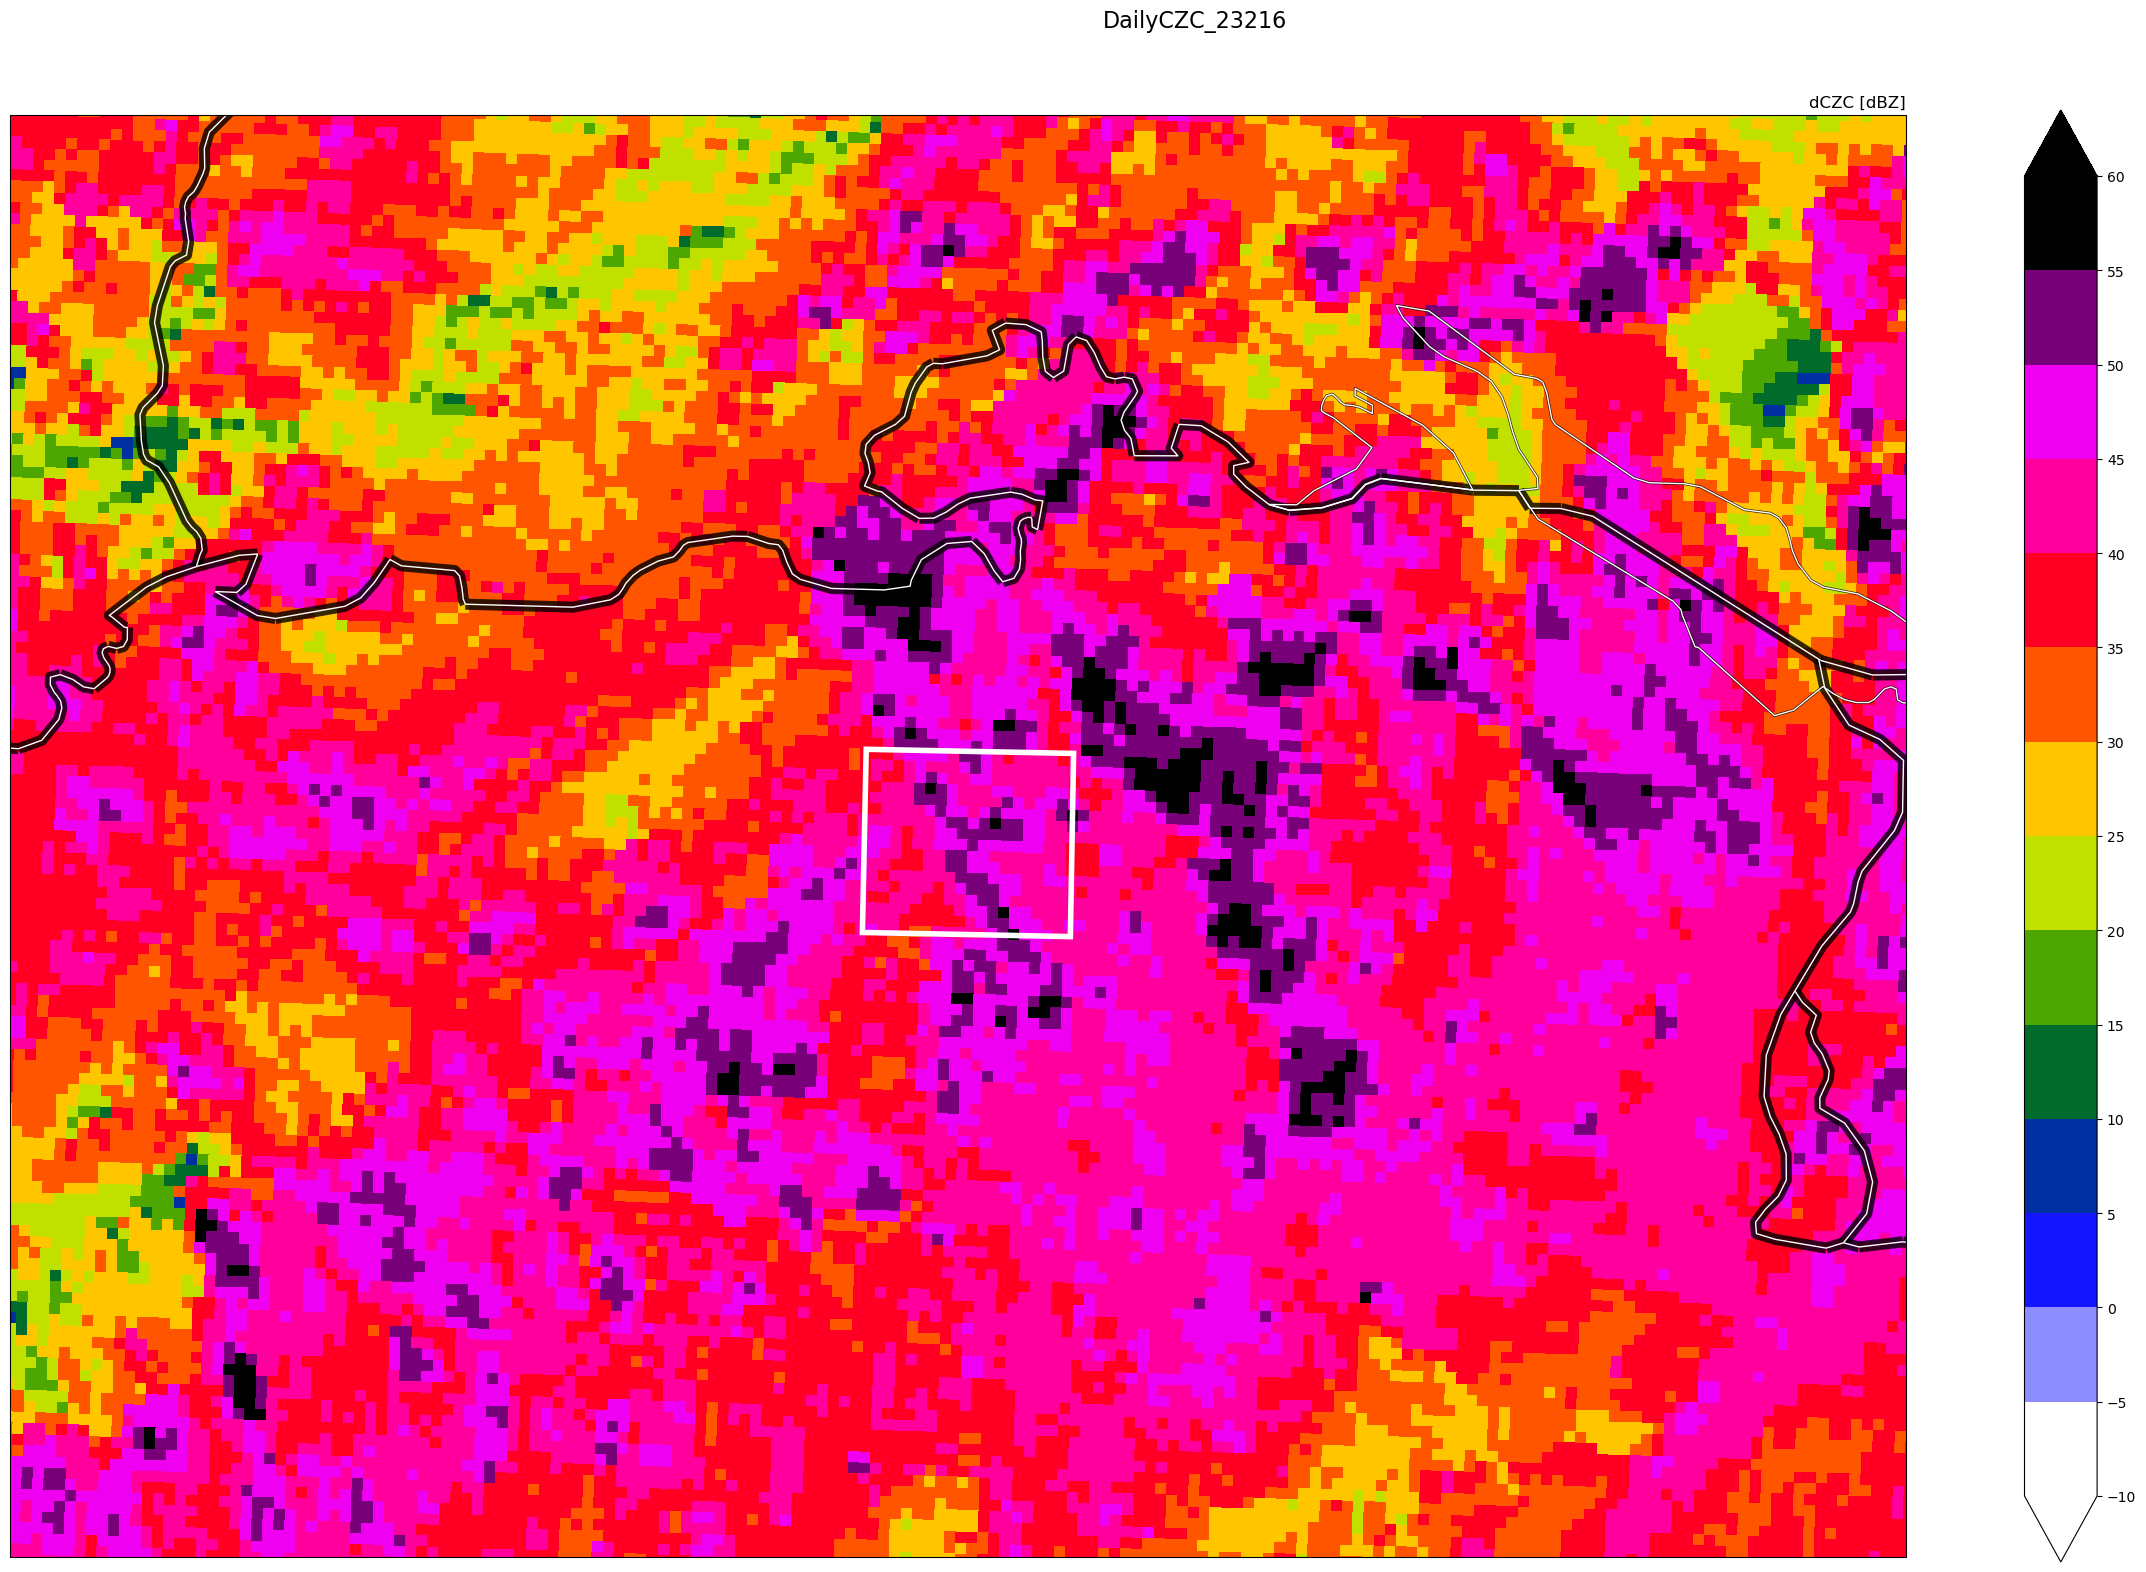

In [ ]:
# Daily max echo over Zurich

projection = ccrs.epsg(3035)
# Create figure
fig, ax = plt.subplots(figsize=(24, 16), subplot_kw={'projection': projection})

edgecolor='black'

# Plot Reflectivity composite
cmap_czc.set_bad(color='grey')
p1 = ax.pcolormesh(clons, clats, dCZC, cmap=cmap_czc, norm=czc_norm, transform=projection)
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=ax, extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor(edgecolor)
cbar1.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color=edgecolor)
ax.set_title('dCZC [dBZ]', color=edgecolor, loc='right')


ax.set_extent(Zurich_extent, crs=ccrs.PlateCarree())
        # Add geographic features
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=8)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-')
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=1)
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=1)

import matplotlib.patches as patches


# Create a Rectangle patch
zurich_rect = patches.Rectangle(
    (zurich_coords[0][0], zurich_coords[0][1]),
    zurich_coords[2][0] - zurich_coords[0][0],
    zurich_coords[2][1] - zurich_coords[0][1],
    linewidth=4,
    edgecolor='white',
    facecolor='none',
    transform=ccrs.PlateCarree()
)

# Add the patch to the Axes
ax.add_patch(zurich_rect)



# Set main title
plt.suptitle("DailyCZC_" + day , color=edgecolor, fontsize=16)
# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])

#plt.savefig("/users/fackerma/newproject1/figures/negative_cases/dCZC_" + day, dpi=300)

In [270]:
# Defining valid time 
day = '23216'
# 23216 23239
valid_time3 = '1650'
elevation_scan = '3'
radar_station = 'A'
radar_name = 'Albis'

In [265]:
# Data Imports, processing, norming, etc.

# GPSConverter for coordinate transformation
class GPSConverter(object):
    '''
    GPS Converter class which is able to perform convertions between the 
    CH1903 and WGS84 system.
    '''
    # Convert CH y/x/h to WGS height
    def CHtoWGSheight(self, y, x, h):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        h = (h + 49.55) - (12.60 * y_aux) - (22.64 * x_aux)
        return h

    # Convert CH y/x to WGS lat
    def CHtoWGSlat(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lat = (16.9023892 + (3.238272 * x_aux)) + \
                - (0.270978 * pow(y_aux, 2)) + \
                - (0.002528 * pow(x_aux, 2)) + \
                - (0.0447 * pow(y_aux, 2) * x_aux) + \
                - (0.0140 * pow(x_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lat = (lat * 100) / 36
        return lat

    # Convert CH y/x to WGS long
    def CHtoWGSlng(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lng = (2.6779094 + (4.728982 * y_aux) + \
                + (0.791484 * y_aux * x_aux) + \
                + (0.1306 * y_aux * pow(x_aux, 2))) + \
                - (0.0436 * pow(y_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lng = (lng * 100) / 36
        return lng

    # Convert decimal angle (° dec) to sexagesimal angle (dd.mmss,ss)
    def DecToSexAngle(self, dec):
        degree = int(math.floor(dec))
        minute = int(math.floor((dec - degree) * 60))
        second = (((dec - degree) * 60) - minute) * 60
        return degree + (float(minute) / 100) + (second / 10000)
		
    # Convert sexagesimal angle (dd.mmss,ss) to seconds
    def SexAngleToSeconds(self, dms):
        degree = 0 
        minute = 0 
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return second + (minute * 60) + (degree * 3600)

    # Convert sexagesimal angle (dd.mmss) to decimal angle (degrees)
    def SexToDecAngle(self, dms):
        degree = 0
        minute = 0
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return degree + (minute / 60) + (second / 3600)
    
    # Convert WGS lat/long (° dec) and height to CH h
    def WGStoCHh(self, lat, lng, h):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        h = (h - 49.55) + (2.73 * lng_aux) + (6.94 * lat_aux)
        return h

    # Convert WGS lat/long (° dec) to CH x
    def WGStoCHx(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        x = ((200147.07 + (308807.95 * lat_aux) + \
            + (3745.25 * pow(lng_aux, 2)) + \
            + (76.63 * pow(lat_aux,2))) + \
            - (194.56 * pow(lng_aux, 2) * lat_aux)) + \
            + (119.79 * pow(lat_aux, 3))
        return x

	# Convert WGS lat/long (° dec) to CH y
    def WGStoCHy(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        y = (600072.37 + (211455.93 * lng_aux)) + \
            - (10938.51 * lng_aux * lat_aux) + \
            - (0.36 * lng_aux * pow(lat_aux, 2)) + \
            - (44.54 * pow(lng_aux, 3))
        return y

    def LV03toWGS84(self, east, north, height):
        '''
        Convert LV03 to WGS84 Return a array of double that contain lat, long,
        and height
        '''
        d = []
        d.append(self.CHtoWGSlat(east, north))
        d.append(self.CHtoWGSlng(east, north))
        d.append(self.CHtoWGSheight(east, north, height))
        return d
        
    def WGS84toLV03(self, latitude, longitude, ellHeight):
        '''
        Convert WGS84 to LV03 Return an array of double that contaign east,
        north, and height
        '''
        d = []
        d.append(self.WGStoCHy(latitude, longitude))
        d.append(self.WGStoCHx(latitude, longitude))
        d.append(self.WGStoCHh(latitude, longitude, ellHeight))
        return d
        
if __name__ == "__main__":
    ''' Example usage for the GPSConverter class.'''

    converter = GPSConverter()

    # Coordinates
    wgs84 = []
    lv03  = [567719, 155077, 1974]
    #567719/ 155077  Altitude: 1974
    # Convert WGS84 to LV03 coordinates
    wgs84 = converter.LV03toWGS84(lv03[0], lv03[1], lv03[2])

    print("WGS84: ")
    print(wgs84)
    print("LV03: ")
    print(lv03)

# Transform function for dealiased velocity
def transform_from_digital(mydata, nyquist):
    myfinaldata = (mydata * 1.0 - 128) * nyquist / 127
    myfinaldata[mydata == 0] = np.nan
    return myfinaldata

# Convert polar coordinates (range, azimuth) to geographic coordinates (lat/lon)
def radar_to_latlon(radar_lat, radar_lon, ranges, azimuths):
    R = 6371.0  # Earth radius in kilometers
    azimuths_rad = np.radians(azimuths)
    latitudes = np.zeros((len(azimuths), len(ranges)))
    longitudes = np.zeros((len(azimuths), len(ranges)))

    for i, az in enumerate(azimuths_rad):
        latitudes[i, :] = radar_lat + (ranges / R) * np.cos(az) * (180.0 / np.pi)
        longitudes[i, :] = radar_lon + (ranges / R) * np.sin(az) * (180.0 / np.pi) / np.cos(np.radians(radar_lat))

    return latitudes, longitudes

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data=pd.read_csv(file).iloc[8:]
        headers=pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df=pd.DataFrame()
        for n in range(len(data)):
            t=data.iloc[n].str.split(';',expand=True)
            trt_df.loc[n,'traj_ID']=int(t[0].values)
            trt_df.loc[n,'time']=int(t[1].values)
            trt_df.loc[n,'lon']=t[2].values.astype(float)
            trt_df.loc[n,'lat']=t[3].values.astype(float)
            chx,chy=c_transform([trt_df.loc[n,'lon']],[trt_df.loc[n,'lat']])
            ix=np.round((chx-o_x)/1000).astype(int)
            if ix>=710: ix=709
            iy=np.round((chy-o_y)/1000).astype(int)
            if iy>=640: iy=639
            n2=27
            if int(ttime)>=221520631: n2=82
            tt=np.array(t)[0,n2:-1]
            tt=np.reshape(tt,[int(len(tt)/2),2])
            trt_df.loc[n,'chx']=chx
            trt_df.loc[n,'chy']=chy
            lat=tt[:,1].astype(float); lon=tt[:,0].astype(float)
            # trt_df=trt_df.astype(str)
            chx,chy=c_transform(lon,lat)
            ix=np.round((chx-o_x)/1000).astype(int)
            iy=np.round((chy-o_y)/1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr,cc]=int(t[0].values);
    # print(np.nanmax(cells))
    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = int(t[0].values)
            trt_df.loc[n, 'time'] = int(t[1].values)
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define VAD reading function
def read_VAD(file_VAD):
    mydoc = xml.dom.minidom.parse(file_VAD)

    levels = mydoc.getElementsByTagName('level')
   
    heights = mydoc.getElementsByTagName('height')
    speeds = mydoc.getElementsByTagName('speed')
    directions = mydoc.getElementsByTagName('direction')
   
    vad_levels=np.zeros(len(levels))
    vad_heights=np.zeros(len(levels))
    vad_speeds=np.zeros(len(levels))
    vad_directions=np.zeros(len(levels))
    for m in range(0,len(levels)):
        vad_levels[m]=levels[m].firstChild.data
        vad_heights[m]=heights[m].firstChild.data
        vad_speeds[m]=speeds[m].firstChild.data
        vad_directions[m]=directions[m].firstChild.data
    vad_s=np.zeros(150); vad_d=np.zeros(150); vad_s[:]=np.nan; vad_d[:]=np.nan;
    for n in range(0,150):
        for m in range(0,len(levels)):
            if vad_levels[m]==n:
                vad_s[n]=vad_speeds[m]
                vad_d[n]=vad_directions[m]
       
       
    vad_u = np.multiply(vad_s, np.cos(np.radians(vad_d)))
    vad_v = np.multiply(vad_s, np.sin(np.radians(vad_d)))
   
    vadu=np.zeros(15); vadv=np.zeros(15);
    for n in range(0,15):
        a=n*10
        vadu[n]=np.nanmean(vad_u[a:a+10])
        vadv[n]=np.nanmean(vad_v[a:a+10])
       
    return vadu, vad_u, vadv, vad_v

# Function to calculate azimuth angle from radar to downburst location
def calculate_azimuth(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Calculate azimuth
    delta_lon = lon2 - lon1
    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)
    azimuth = math.atan2(x, y)
    azimuth_deg = math.degrees(azimuth)
    
    # Normalize to 0-360 degrees
    return (azimuth_deg + 360) % 360

# Convolves and normalizes 2D data with a 3x3 kernel
def conv(data):
    """
    Convolves and normalizes 2D data with a 3x3 kernel

    Parameters
    ----------
    data : 2-D array
        data to be convolved.

    Returns
    -------
    d_conv : 2-D array
        convolved data.

    """
    ## convolves 2D data with a 3x3 kernel, equal weights, wrapped boundary, NaN values ignored / filled in
    g_kernel=np.ones([3,3])/9
    d_conv=convolve(data,g_kernel, boundary='wrap')
    return d_conv

# azimuthal centered difference derivative for polar data -> wraps around 0/360
def az_cd(myfinaldata, nyquist, threshold, resolution, min_size):
    """
    azimuthal centered difference derivative for polar data -> wraps around 0/360

    Parameters
    ----------
    myfinaldata : 2D array
        input data.
    nyquist : float
        Nyquist velocity of raw velocity data.
    threshold : float
        shear correction threshold.
    resolution : float
        radial resolution of data.
    min_size : int
        minimum number of gates required for correction.

    Returns
    -------
    myshear_cor : 2D array
        azimuthal derivative, corrected for unfolding errors.
    mygateshear_cor : 2D array
        azimuthal difference (no normalization by distance), corrected for unfolding errors.

    """
    ## azimuthal derivative, centered difference
    ## corrects for anomalous shear exceeding threshold
    ## shear only corrected if contiguous area of several pixels
    myfinaldata_1=np.zeros(myfinaldata.shape)
    myfinaldata_1[:-1,:]=myfinaldata[1:,:]
    myfinaldata_1[-1,:]=myfinaldata[0,:]
    myfinaldata_2=np.zeros(myfinaldata.shape)
    myfinaldata_2[1:,:]=myfinaldata[:-1,:]
    myfinaldata_2[0,:]=myfinaldata[-1,:]
    
    distance=np.arange(0.5*resolution, myfinaldata.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,myfinaldata.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)
    
    myshear_1=(myfinaldata-myfinaldata_1)/(2*distance)*-(1)
    myshear_2=(myfinaldata_2-myfinaldata)/(2*distance)*(-1)
    myshear_3=(myfinaldata_2-myfinaldata_1)/(2*distance)*(-1)
    
    myshear_1_cor=shear_cor(myshear_1, distance, threshold, nyquist, min_size)
        
    myshear_2_cor=shear_cor(myshear_2, distance, threshold, nyquist, min_size)

    myshear_3_cor=shear_cor(myshear_3, distance, threshold, nyquist, min_size)
    
    myshear_cor=np.nansum([myshear_2_cor,myshear_1_cor],axis=0)
    myshear_cor[np.isnan(myfinaldata)==1]=myshear_3_cor[np.isnan(myfinaldata)==1]
    mygateshear_cor=myshear_cor*distance
    
    return myshear_cor, mygateshear_cor

# Identifies unfolding errors in derivative and corrects for them
def shear_cor(myshear, distance, threshold, nyquist, min_size):
    """
    Identifies unfolding errors in derivative and corrects for them

    Parameters
    ----------
    myshear : 2D array
        input data.
    distance : 2D array
        azimuthal Cartesian distance between gates.
    threshold : float
        error identification threshold.
    nyquist : float
        correction interval (nyquist velocity).
    min_size : int
        minimum number of connected erroneous gates.

    Returns
    -------
    myshear_cor : 2D array
        corrected data.

    """
    ## function embedded in centered difference shear
    ## eliminates anomalous shear in contiguous area
    myshear_cor=(myshear*(2*distance))
    thresh_1=(myshear*(2*distance))-threshold
    thresh_2=(myshear*(2*distance))+threshold
    
    mybin_pos=np.zeros(myshear.shape)
    mybin_pos[thresh_1>=0]=1
    labels, n_groups=ndi.label(mybin_pos)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] -= (2*nyquist)
    
    mybin_neg=np.zeros(myshear.shape)
    mybin_neg[thresh_2<=0]=1
    labels, n_groups=ndi.label(mybin_neg)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] += (2*nyquist)
    myshear_cor=myshear_cor/(2*distance)
    return myshear_cor

# azimuthal linear least squares derivative        
def az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    azimuthal linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    az_shear : array of same dimensions as data
        azimuthal derivative of data.

    """
    ##azimuthal linear least squares derivative
    az_shear=( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k_thet * ( - np.sum(weights * d_r * d_r) * np.sum(weights) + np.sum(weights * d_r) * np.sum(weights * d_r)) \
                + u_k * (np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) - np.sum(weights * d_r) * np.sum(weights * d_r * d_theta)) )
    return az_shear

# radial linear least squares derivative
def div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    radial linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    div_shear : array of same dimensions as data
        radial derivative of data.

    """
    ##radial linear least squares derivative
    div_shear= ( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (- np.sum(weights * d_theta * d_theta) * np.sum(weights) + np.sum(weights * d_theta) * np.sum(weights * d_theta)) \
                + u_k_thet * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k * ( - np.sum(weights * d_r * d_theta) * np.sum(weights * d_theta) + np.sum(weights * d_r) * np.sum(weights * d_theta * d_theta)) )
    return div_shear

# full linear least squares derivative
def llsd(vel, az_min, az_max, w_k, r_k, resolution):
    """
    full linear least squares derivative

    Parameters
    ----------
    vel : 2D array
        input data, polar data.
    az_min : int
        min. number of gates in azimuth.
    az_max : int
        max. number of gates in azimuth.
    w_k : float
        kernel width in azimuth (Cartesian).
    r_k : float
        kernel width in radial (Cartesian).
    resolution : float
        radial resolution.

    Returns
    -------
    az_shear : 2D array
        azimuthal derivative.
    div_shear : 2D array
        radial derivative.

    """
    ##complete linear least squares derivative
    az_shear=np.zeros(vel.shape); az_shear[:]=np.nan
    div_shear=np.zeros(vel.shape); div_shear[:]=np.nan
    
    distance=np.arange(0.5*resolution, vel.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,vel.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)

    r_h=int(np.floor(az_max/2))
	
    for n2 in range(r_h,vel.shape[1]-r_h):
        
        az_w=int(np.round(w_k/distance[1,n2]));
        if az_w%2 == 0: az_w+=1
        if az_w>az_max: az_w=az_max
        if az_w<az_min: az_w=az_min
        az_r=int(np.floor(az_w/2))
        
        r_w= r_k/resolution;
        if r_w%2 == 0: r_w+=1
        r_w=int(r_w)
        r_r=r_w*resolution
        r_vec=np.arange(-r_r,r_r+resolution,resolution)
        r_vec=np.expand_dims(r_vec,axis=0)
        d_r=np.repeat(r_vec,az_w,axis=0)
        
        d_r=np.zeros([az_w,r_w])
        for n2_2 in range(0,r_w):
            d_r[:,n2_2]=-r_k*n2_2/(r_w-1)+r_k*0.5
        rw_f=int(np.floor(r_w/2))
	    
        d_r2=-copy.deepcopy(d_r); #print(d_r.shape,n2)
        weights=np.ones([az_w,r_w])
        d_theta=copy.deepcopy(distance[:az_w,n2-rw_f:n2+rw_f+1]); d_theta[az_r,:]=0
        d_theta[:az_r,:]=-d_theta[:az_r,:];
        d_thet=copy.deepcopy(d_theta); d_thet=-np.flip(d_thet,1)

        u_k=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],weights,mode='same',boundary='wrap')[:,1]
        u_k_thet=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_thet,mode='same',boundary='wrap')[:,1]
        u_k_r=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_r2,mode='same',boundary='wrap')[:,1]

        az_shear[:,n2]= az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
        div_shear[:,n2]= div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
    return az_shear, div_shear

# c_transform
def c_transform(lon,lat):
    """
    transforms arrays of lat/lon to chx/chy

    Parameters
    ----------
    lon : float
        longitude.
    lat : float
        latitude.

    Returns
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.

    """
    converter = GPSConverter()
    chx=np.zeros([len(lon)])
    chy=np.zeros([len(lon)])
    for n in range(len(lon)):
        chx[n],chy[n],z=converter.WGS84toLV03(lat[n], lon[n], 0)
    return chx,chy

# transform_c 
def transform_c(chx,chy):
    """
    transforms arrays of chx/chy to lat/lon
    
    Parameters
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.
        
    Returns
    ----------
    lon : float
        longitude.
    lat : float
        latitude.



    """
    converter = GPSConverter()
    lon=np.zeros([len(chx)])
    lat=np.zeros([len(chy)])
    for n in range(len(lon)):
        lat[n], lon[n],z=converter.LV03toWGS84(chx[n],chy[n], 0)
    return lon,lat

# Get trajectory ID
def get_traj_id_for_location(df, lon, lat, time):
    point = Point(lon, lat)
    df_at_time = df[df['yyyymmddHHMM'].astype(str).str[-4:] == time]
    containing_cells = df_at_time[df_at_time.contains(point)]
    return containing_cells['traj_ID'].iloc[0] if not containing_cells.empty else None

# Calculate mean propagation speed for a TRT cell
def calculate_mean_speed(df, traj_id, center_time, time_range_minutes):
    center_dt = datetime.strptime(center_time, '%H%M')
    start_dt = center_dt - timedelta(minutes=time_range_minutes)
    end_dt = center_dt + timedelta(minutes=time_range_minutes)
    
    time_range = [(start_dt + timedelta(minutes=5*i)).strftime('%H%M') for i in range(2*time_range_minutes//5 + 1)]
    
    df['vel_x'] = pd.to_numeric(df['vel_x'], errors='coerce')
    df['vel_y'] = pd.to_numeric(df['vel_y'], errors='coerce')
    df['propagation_speed'] = np.sqrt(df['vel_x']**2 + df['vel_y']**2)
    
    speeds = df[(df['traj_ID'] == traj_id) & (df['yyyymmddHHMM'].astype(str).str[-4:].isin(time_range))]['propagation_speed']
    
    return speeds.mean() if not speeds.empty else None

# Calculate Swiss grid coordinates into composite raster points
def swiss_to_grid_index(swiss_x, swiss_y, clons, clats, zh_shape):
    # Initialize transformers
    transformer_swiss_to_3035 = Transformer.from_crs(21781, 3035, always_xy=True)
    
    # Transform Swiss coordinates to EPSG:3035
    x_3035, y_3035 = transformer_swiss_to_3035.transform(swiss_x, swiss_y)
    
    # Calculate distances
    distances = np.sqrt((clons - x_3035)**2 + (clats - y_3035)**2)
    
    # Find the index of the minimum distance
    y_idx, x_idx = np.unravel_index(np.argmin(distances), distances.shape)
    
    # Create a function to get values at specific vertical levels
    def get_value_at_level(zh_array, level):
        if 0 <= level < zh_shape[2]:
            return zh_array[y_idx, x_idx, level]
        else:
            raise ValueError(f"Level must be between 0 and {zh_shape[2]-1}")
    
    return y_idx, x_idx, get_value_at_level

# Load and create cross sections of the wind composite
def load_and_create_cross_sections(year, month, day, valid_time):
    # Load the .npz file
    data = np.load(f'/scratch/mch/fackerma/orders/full_composite_npz/{year}{month}{day}{valid_time}00_conv_wind_composite_data.npz')
    
    # Access the specific arrays
    ZH = data['ZH_max']
    rad_shear = data['RAD_SHEAR_LLSD_max']
    az_shear = data['AZ_SHEAR_LLSD_abs_max']
    RVEL = data['RVEL_DE_abs_max']
    KDP = data['KDP_max']
    ZDR = data['ZDR_max']
    
    # Create cross-sections and 2D projections for each array
    arrays = [ZH, rad_shear, az_shear, RVEL, KDP, ZDR]
    names = ['ZH', 'rad_shear', 'az_shear', 'RVEL', 'KDP', 'ZDR']
    
    results = {}
    
    for arr, name in zip(arrays, names):
        # Create cross-sections
        results[f'{name}_x_cross'] = arr[y_idx, x_start:x_end, :]
        results[f'{name}_y_cross'] = arr[y_start:y_end, x_idx, :]
        
        # Create 2D max projection
        results[f'{name}_2d'] = np.nanmax(arr, axis=2)
    
    return results
# All results are stored in a dictionary, with keys formatted as '{name}_x_cross', '{name}_y_cross', and '{name}_2d'



# Radar locations
if radar_station=='L':
    radar_lat = 46.0401
    radar_lon = 8.8334
    radar_alt = 1627 
if radar_station=='P':
    radar_lat = 46.37083
    radar_lon = 7.48694
    radar_alt = 2927
if radar_station=='W':
    radar_lat = 46.832
    radar_lon = 9.796
    radar_alt = 2892 
if radar_station=='A':
    radar_lat = 47.2841
    radar_lon = 8.5117
    radar_alt = 938 
if radar_station=='D':
    radar_lat = 46.425676
    radar_lon = 6.100092
    radar_alt = 1670

# Coordinates of cities
locarno_lat = 46.1700
locarno_lon = 8.7996
lugano_lat = 46.0037
lugano_lon = 8.9511

# Load radar data
path = '/scratch/mch/fackerma/orders/negative_cases/case_040823'

file = glob.glob(path + '/ML/ML' + radar_station + day + valid_time3 + '0U.00' + elevation_scan)
file2 = glob.glob(path +'/DV/srn/data/tmp/mof/DV' + radar_station + '/DV' + radar_station + day + valid_time3 + '7L.80' + elevation_scan) # Dealiased velocity
file3 = glob.glob(path +'/HZC/HZC' + day + valid_time3 + 'VL.801') # Freezing level height composite
#file4 = glob.glob(path +'/VAL/VA' + radar_station + '21194' + valid_time3 + '7U.019') # Vertical wind profile above radar
file5 = glob.glob(path +'/BZC/BZC' + day + valid_time3 + 'VL.845') # POH
file6 = glob.glob(path +'/MZC/MZC' + day + valid_time3 + 'VL.850') # MESH
file7 = glob.glob(path +'/TRTC/CZC' + day + valid_time3 + '0T.rdt') # Thunderstorm radar tracking; or .rdt .trt
file8 = glob.glob(path +'/CZC/CZC' + day + valid_time3 + 'VL.801') # Reflectivity composite
file9 = glob.glob(path +'/LZC/LZC' + day + valid_time3 + 'VL.801') # VIL composite
file10 = glob.glob(path +'/EZC/EZC' + day + valid_time3 + 'VL.820') # Echotops composite: 815, 820, 845, 850
file11 = glob.glob(path +'/OZC/OZC' + day + valid_time3 + 'VL.830') # CAPPI composite, ranging from 810 to 980 in steps of 10
file12 = glob.glob(path + '/dARC/ARC'+ day + '0000FF.1440') # daily bias corrected rain accumulation
file13 = glob.glob(path + '/dBZC/BZC' + day + '2400VL.845') # daily POH
#file14 = glob.glob(path + '/dRZC/RZC'+day+'2400VL.801') # daily Rain Rate
file15 = glob.glob(path + '/dCZC/CZC'+day+'2400VL.801') # daily Max Echo


# Read the data for the plots
data = pyart.aux_io.read_metranet(file[0], reader='python')
velocity = data.get_field(0, 'velocity').data
reflectivity = data.get_field(0, 'reflectivity').data

dv_data = pyart.aux_io.read_file_py(file2[0], physic_value=False)
dv_digital = dv_data.data
dv_header = dv_data.header
nyq = float(dv_header['nyquist'])
dv_velocity = transform_from_digital(dv_digital, nyq)

hzc_data = radlib.read_file(file3[0],physic_value=True)
hzc=hzc_data.data

dARC_data = radlib.read_file(file12[0],physic_value=True)
dARC=dARC_data.data

dBZC_data = radlib.read_file(file13[0],physic_value=True)
dBZC=dBZC_data.data

#dRZC_data = radlib.read_file(file14[0],physic_value=True)
#dRZC=dRZC_data.data

dCZC_data = radlib.read_file(file15[0],physic_value=True)
dCZC=dCZC_data.data

diff_reflectivity = data.get_field(0, 'differential_reflectivity').data

diff_phase = data.get_field(0, 'uncorrected_differential_phase').data

cc_ratio = data.get_field(0, 'uncorrected_cross_correlation_ratio').data

mzc_data = radlib.read_file(file6[0],physic_value=True)
mzc=mzc_data.data

bzc_data = radlib.read_file(file5[0],physic_value=True)
bzc=bzc_data.data

specw = data.get_field(0, 'spectrum_width').data

czc_data = radlib.read_file(file8[0],physic_value=True)
czc=czc_data.data

lzc_data = radlib.read_file(file9[0],physic_value=True)
lzc=lzc_data.data

ezc_data = radlib.read_file(file10[0],physic_value=True)
ezc=ezc_data.data

ozc_data = radlib.read_file(file11[0],physic_value=True)
ozc=ozc_data.data


valid_time4 = valid_time3 + '0'
path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/negative_cases/case_040823/"}  # Replace with your actual path
trt_df, cells_list, timelist = read_TRT(path_trtc, ttime=valid_time4)
# Extract the first element from the list of cells
cells = cells_list[0]
# Define Swiss CH1903 to WGS84 transformer
transformer_trtc = Transformer.from_crs("epsg:21781", "epsg:4326", always_xy=True)
# Grid dimensions and origin
o_x, o_y = 255000, -160000  # Origin in Swiss coordinates
lx, ly = 710, 640           # Grid size (width x height)
cell_size = 1000            # 1 km grid spacing
# Create Swiss grid (CH1903 coordinates)
x_coords = np.linspace(o_x, o_x + (lx - 1) * cell_size, lx)
y_coords = np.linspace(o_y, o_y + (ly - 1) * cell_size, ly)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
# Convert grid to WGS84 (longitude, latitude)
lon_trtc, lat_trtc = transformer_trtc.transform(x_grid, y_grid)

#vad = read_VAD(file4[0])

# Convert echotop18 from km to meters
ezc_m = ezc * 1000
# Compute the wind gust estimator 'wge' (Trefalt 2017)
wge = np.sqrt((-3.1 * 10**-6 * (ezc**2)) + (20.6 * lzc))


resolution = 0.5
range_max = reflectivity.shape[1] * resolution
azimuths = np.linspace(0, 360, reflectivity.shape[0])
ranges = np.arange(0, range_max, resolution)

# Kdp own method
smoothed_diff_phase = gaussian_filter1d(diff_phase, sigma=2, axis=1) 
Kdp = np.gradient(smoothed_diff_phase, ranges, axis=1)

# KDP Vulpiani Method
Kdp = pyart.retrieve.kdp_vulpiani(data, psidp_field='uncorrected_differential_phase', band='C', parallel=True)
Kdp = Kdp[0]['data']

llsd_vel = llsd(vel=dv_velocity, az_min=3, az_max=90, w_k=2, r_k=2, resolution=0.5)




# Transform radar polar coordinates to lat/lon
lats, lons = radar_to_latlon(radar_lat, radar_lon, ranges, azimuths)

# Define the Swiss grid (values based on metadata)
chx = np.arange(255000, 255000 + 710 * 1000 + 1, 1000)
chy = sorted(np.arange(-160000, -160000 + 640 * 1000 + 1, 1000), reverse=True)
X, Y = np.meshgrid(chx, chy)
# Initialize transformer for Swiss grid 
transformer = Transformer.from_crs(21781, 3035, always_xy=True)

#lons,lats = transformer.transform(X, Y)
clons, clats = transformer.transform(X, Y)
#lons, lats = transformer.transform(X, Y)

cmap_czc = LinearSegmentedColormap.from_list("custom_cmap", ["black","white", "blue", "green", "yellow","red","magenta"], N=256)
czc_levels = np.arange(-10, 65, 5)  # Steps of 2 for Reflectivity
czc_norm = BoundaryNorm(boundaries=czc_levels, ncolors=256, clip=True)
# Define color steps for Reflectivity and Velocity/Dealiased Velocity
reflectivity_levels = np.arange(-5, 65, 5)  # Steps of 2 for Reflectivity
velocity_levels = np.arange(-25, 26, 5)  # Steps of 1 for Velocity and Dealiased Velocity
hzc_levels = np.arange(1, 10, 1)
diff_reflectivity_levels = np.arange(-1,3.5,0.5)
diff_phase_levels = np.arange(-70,90,20)
cc_ratio_levels = np.arange(0.7,1,0.05)
mzc_levels = np.arange(0,5.5,0.5)
bzc_levels = np.arange(0,101,10)
specw_levels = np.arange(0,7,1)
Kdp_levels = np.arange(0,5.5,0.5)
lzc_levels = np.arange(2.5,25,2.5)
ezc_levels = np.arange(2,16,2)
wge_levels = np.arange(2,20,2)
az_shear_levels = np.arange(-5,5.5,1)
div_shear_levels = np.arange(-5,5.5,1)
# Create boundary norms
reflectivity_norm = BoundaryNorm(boundaries=reflectivity_levels, ncolors=plt.cm.inferno.N, clip=True)
velocity_norm = BoundaryNorm(boundaries=velocity_levels, ncolors=256, clip=True)
hzc_norm = BoundaryNorm(boundaries=hzc_levels, ncolors=256, clip=True)
diff_reflectivity_norm = BoundaryNorm(boundaries=diff_reflectivity_levels, ncolors=256, clip=True)
diff_phase_norm = BoundaryNorm(boundaries=diff_phase_levels, ncolors=256, clip=True)
cc_ratio_norm = BoundaryNorm(boundaries=cc_ratio_levels, ncolors=256, clip=True)
mzc_norm = BoundaryNorm(boundaries=mzc_levels, ncolors=256, clip=True)
bzc_norm = BoundaryNorm(boundaries=bzc_levels, ncolors=256, clip=True)
specw_norm = BoundaryNorm(boundaries=specw_levels, ncolors=256, clip=True)
Kdp_norm = BoundaryNorm(boundaries=Kdp_levels, ncolors=256, clip=True)
lzc_norm = BoundaryNorm(boundaries=lzc_levels, ncolors=256, clip=True)
ezc_norm = BoundaryNorm(boundaries=ezc_levels, ncolors=256, clip=True)
wge_norm = BoundaryNorm(boundaries=wge_levels, ncolors=256, clip=True)
az_shear_norm = BoundaryNorm(boundaries=az_shear_levels, ncolors=256, clip=True)
div_shear_norm = BoundaryNorm(boundaries=div_shear_levels, ncolors=256, clip=True)

cmap_velocity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"], N=256)
cmap_hzc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "dodgerblue", "midnightblue"], N=256)
cmap_diff_reflectivity = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_diff_phase = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white","red"], N=256)
cmap_cc_ratio = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_Kdp = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_bzc = LinearSegmentedColormap.from_list("custom_cmap", ["black","yellow", "red"], N=256)
cmap_specw = LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue","yellow","orange","red"], N=256)
cmap_lzc = LinearSegmentedColormap.from_list("custom_cmap", ["black", "cyan", "purple"], N=256)
cmap_ezc = plt.cm.Blues
cmap_wge = plt.cm.magma
cmap_vad = plt.cm.Accent
cmap_az_shear = LinearSegmentedColormap.from_list("custom_cmap", ["aqua","blue", "black", "red","yellow"], N=256)
cmap_div_shear = cmap_az_shear

schaden_levels = np.array([0, 1, 3, 5, 10, 20, 50, 100, 150])
schaden_norm= BoundaryNorm(boundaries=schaden_levels, ncolors=256, clip=True)
cmap_schaden = LinearSegmentedColormap.from_list("custom_cmap", ["white","yellow", "orange", "red","purple"], N=256)

# Crowd-sourcing data path
file_cs = '/scratch/mch/fackerma/orders/negative_cases/case_040823/wind_reports_2023_08_04.json'


zurich_coords = [
    (8.4, 47.3),
    (8.4, 47.45),
    (8.65, 47.45),
    (8.65, 47.3)
]

# Extents for plotting
extent_switzerland = [5.77, 10.8, 45.5, 48]
max_extent = [4, 12, 44, 49]
TicinoLarge_extent = [5.5, 10.5, 44.6, 47]
Ticino_extent = [7.7, 9.9, 45.2, 46.65]
Zurich_extent = [7.6,9.45,46.9,47.85]


WGS84: 
[46.54620053012867, 7.017760746224894, 2024.97379732]
LV03: 
[567719, 155077, 1974]
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
py_decoder DBG verb=0
py_decoder DBG verbl=0
swap product table data ......
py_decoder DBG verb=0
py_decoder DBG verbl=0


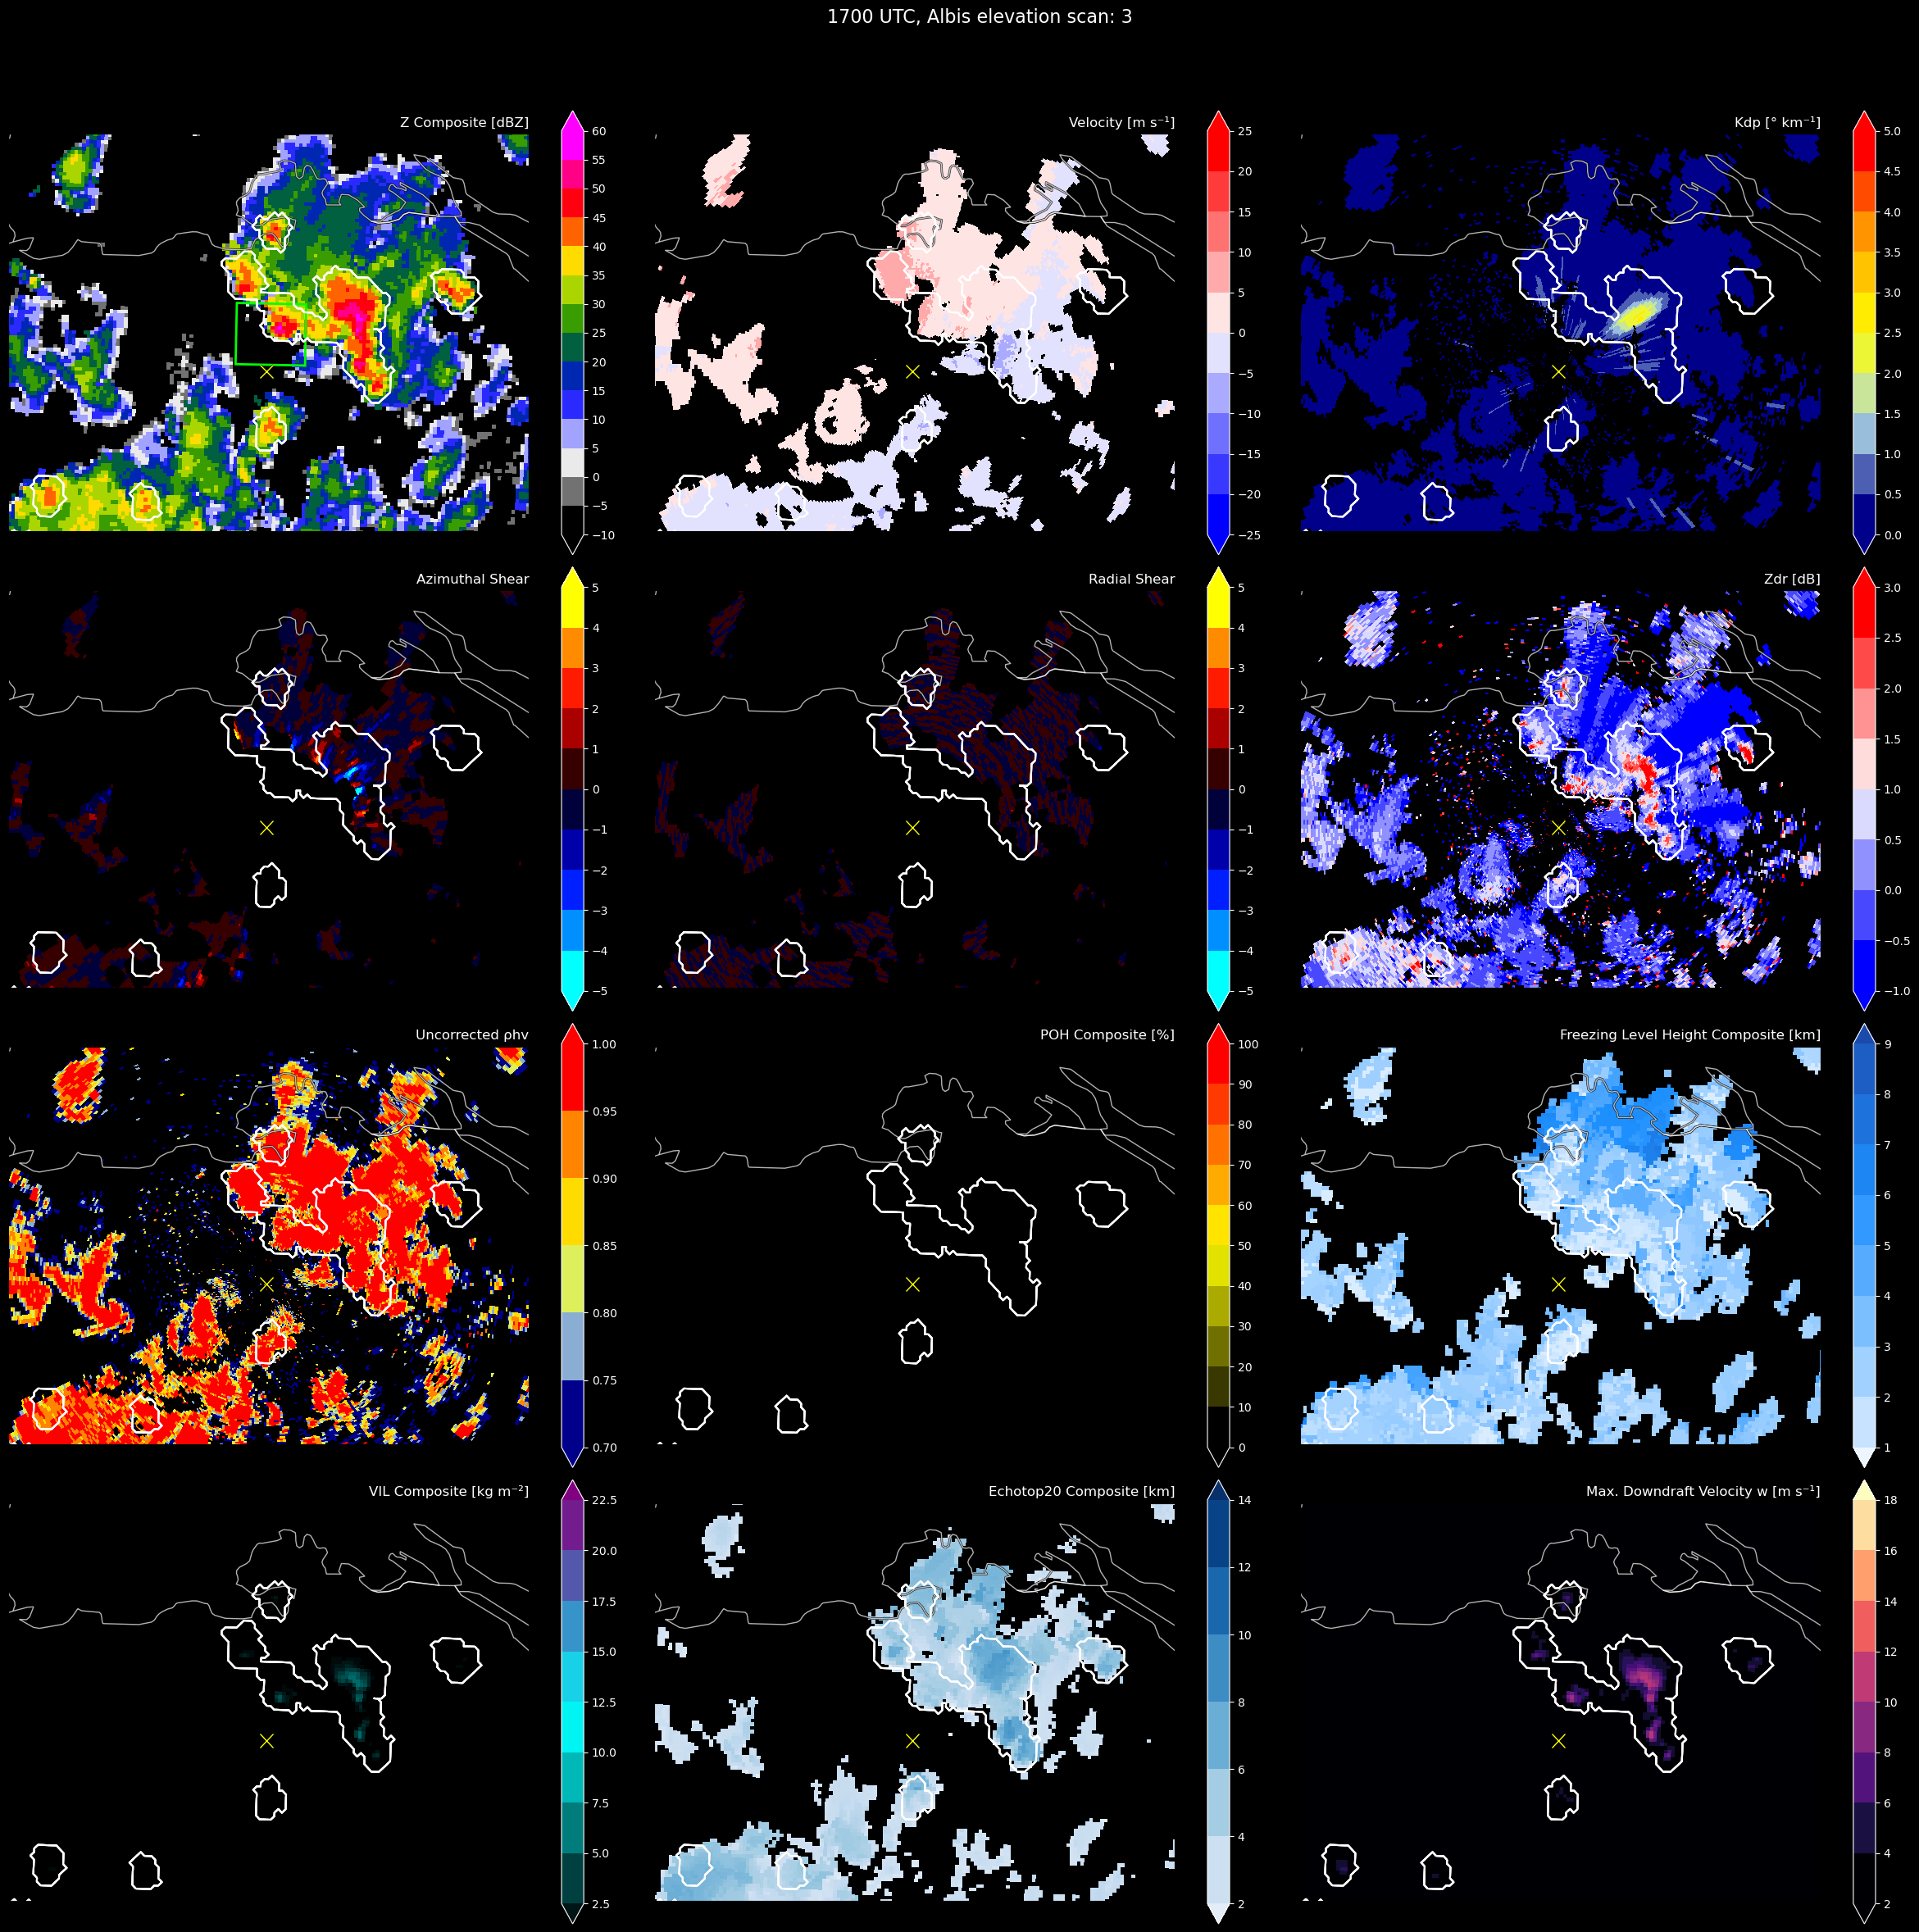

In [138]:
# Multi-variable plot
projection = ccrs.epsg(3035)
# Create figure with three subplots (Reflectivity, Velocity, and Dealiased Velocity)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24, 24), subplot_kw={'projection': projection})

# Set background to black for all subplots
for row in axs:  # axs is a 2D array, so iterate through rows
    for ax in row:  # Iterate through each subplot in the row
        fig.patch.set_facecolor('black')  # Set figure background
        ax.set_facecolor('black')  # Set axis background

# Create a Rectangle patch
zurich_rect = patches.Rectangle(
    (zurich_coords[0][0], zurich_coords[0][1]),
    zurich_coords[2][0] - zurich_coords[0][0],
    zurich_coords[2][1] - zurich_coords[0][1],
    linewidth=2,
    edgecolor='lime',
    facecolor='none',
    transform=ccrs.PlateCarree()
)

# Plot Reflectivity composite
cmap_czc.set_bad(color='grey')
p1 = axs[0,0].pcolormesh(clons, clats, czc, norm=czc_norm,
                   cmap=cmap_czc, transform=projection)
# Add a colorbar
cbar1 = plt.colorbar(p1, ax=axs[0,0], extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels
                     )
cbar1.outline.set_edgecolor('white')
cbar1.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')
axs[0,0].set_title('Z Composite [dBZ]', color='white', loc='right')
axs[0,0].add_patch(zurich_rect)



# Plot Dealiased Velocity
cmap_velocity.set_bad(color='black')
p2 = axs[0,1].pcolormesh(lons, lats, dv_velocity, cmap=cmap_velocity, norm=velocity_norm, transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(p2, ax=axs[0,1], cmap=cmap_velocity, extend='both', boundaries=velocity_levels, ticks=velocity_levels)
cbar2.outline.set_edgecolor('white')
cbar2.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')
axs[0,1].set_title('Velocity [m s⁻¹]', color='white', loc='right')


# Plot Radial shear
#cmap_specw.set_bad(color='black')
p9 = axs[1,1].pcolormesh(lons, lats, llsd_vel[1], cmap=cmap_div_shear, norm=div_shear_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[1,1], cmap=cmap_div_shear, extend='both', boundaries=div_shear_levels, ticks=div_shear_levels
                     )
cbar9.outline.set_edgecolor('white')
cbar9.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color='white')
axs[1,1].set_title('Radial Shear', color='white', loc='right')

# Plot Azmiutal shear
#cmap_specw.set_bad(color='black')
p9 = axs[1,0].pcolormesh(lons, lats, llsd_vel[0], cmap=cmap_az_shear, norm=az_shear_norm, 
                         transform=ccrs.PlateCarree())
cbar9 = plt.colorbar(p9, ax=axs[1,0], cmap=cmap_az_shear, extend='both', boundaries=az_shear_levels, ticks=az_shear_levels
                     )
cbar9.outline.set_edgecolor('white')
cbar9.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar9.ax.axes, 'yticklabels'), color='white')
axs[1,0].set_title('Azimuthal Shear', color='white', loc='right')


# Plot Freezing level height
# Mask values of freezing level height that are 0 or lower
hzc_masked = np.ma.masked_less_equal(hzc, 0)
# Define a custom colormap, setting the under value (for masked/low values) to black
#cmap_hzc.set_under('black')  # Black for values 0 or lower
cmap_hzc.set_bad(color='black')  # Black for invalid data
# Plot the freezing level height with the masked values
p3 = axs[2,2].pcolormesh(clons, clats, hzc_masked, vmin=0, vmax=12, 
                         cmap=cmap_hzc, transform=projection)
# Add a colorbar
cbar3 = plt.colorbar(p3, ax=axs[2,2], extend='both', cmap=cmap_hzc, boundaries=hzc_levels, ticks=hzc_levels)
cbar3.outline.set_edgecolor('white')
cbar3.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar3.ax.axes, 'yticklabels'), color='white')
axs[2,2].set_title('Freezing Level Height Composite [km]', color='white', loc='right')


# Plot Differential Reflectivity
cmap_diff_reflectivity.set_bad(color='black')
p4 = axs[1,2].pcolormesh(lons, lats, diff_reflectivity, cmap=cmap_diff_reflectivity, norm=diff_reflectivity_norm, 
                         transform=ccrs.PlateCarree())
cbar4 = plt.colorbar(p4, ax=axs[1,2], cmap=cmap_diff_reflectivity, extend='both', boundaries=diff_reflectivity_levels, ticks=diff_reflectivity_levels
                     )
cbar4.outline.set_edgecolor('white')
cbar4.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar4.ax.axes, 'yticklabels'), color='white')
axs[1,2].set_title('Zdr [dB]', color='white', loc='right')


# Plot CC ratio
cmap_cc_ratio.set_bad(color='black')
p6 = axs[2,0].pcolormesh(lons, lats, cc_ratio, cmap=cmap_cc_ratio, norm=cc_ratio_norm, 
                         transform=ccrs.PlateCarree())
cbar6 = plt.colorbar(p6, ax=axs[2,0], cmap=cmap_cc_ratio, extend='both', boundaries=cc_ratio_levels, ticks=cc_ratio_levels
                     )
cbar6.outline.set_edgecolor('white')
cbar6.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar6.ax.axes, 'yticklabels'), color='white')
axs[2,0].set_title('Uncorrected ρhv', color='white', loc='right')


# Plot Kdp
cmap_Kdp.set_bad(color='black')
p7 = axs[0,2].pcolormesh(lons, lats, Kdp, norm=Kdp_norm,
                   cmap=cmap_Kdp, transform=ccrs.PlateCarree())
# Add a colorbar
cbar7 = plt.colorbar(p7, ax=axs[0,2], extend='both', cmap=cmap_Kdp, boundaries=Kdp_levels, ticks=Kdp_levels
                     )
cbar7.outline.set_edgecolor('white')
cbar7.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar7.ax.axes, 'yticklabels'), color='white')
axs[0,2].set_title('Kdp [° km⁻¹]', color='white', loc='right')


# Plot POH
cmap_bzc.set_bad(color='black')
p8 = axs[2,1].pcolormesh(clons, clats, bzc, norm=bzc_norm,
                   cmap=cmap_bzc, transform=projection)
# Add a colorbar
cbar8 = plt.colorbar(p8, ax=axs[2,1], extend='both', cmap=cmap_bzc, boundaries=bzc_levels, ticks=bzc_levels
                     )
cbar8.outline.set_edgecolor('white')
cbar8.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar8.ax.axes, 'yticklabels'), color='white')
axs[2,1].set_title('POH Composite [%]', color='white', loc='right')


# Plot VIL composite
#lzc = np.ma.masked_less_equal(lzc, 0.1)
cmap_lzc.set_bad(color='black')
p10 = axs[3,0].pcolormesh(clons, clats, lzc, vmin=1, vmax=22.5, 
                   cmap=cmap_lzc, transform=projection)
# Add a colorbar
cbar10 = plt.colorbar(p10, ax=axs[3,0], extend='both', cmap=cmap_lzc, norm=lzc_norm, boundaries=lzc_levels, ticks=lzc_levels
                     )
cbar10.outline.set_edgecolor('white')
cbar10.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar10.ax.axes, 'yticklabels'), color='white')
axs[3,0].set_title('VIL Composite [kg m⁻²]', color='white', loc='right')

# Plot Echotop 20 composite
# Set a mask
ezc = np.ma.masked_less_equal(ezc, 0)
cmap_ezc.set_bad(color='black')
p11 = axs[3,1].pcolormesh(clons, clats, ezc, vmin=0, vmax=14, 
                   cmap=cmap_ezc, transform=projection)
# Add a colorbar
cbar11 = plt.colorbar(p11, ax=axs[3,1], extend='both', cmap=cmap_ezc, norm=ezc_norm, boundaries=ezc_levels, ticks=ezc_levels
                     )
cbar11.outline.set_edgecolor('white')
cbar11.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar11.ax.axes, 'yticklabels'), color='white')
axs[3,1].set_title('Echotop20 Composite [km]', color='white', loc='right')

# Plot wge composite
# Set a mask
wge = np.ma.masked_less_equal(wge, 0)
cmap_wge.set_bad(color='black')
p12 = axs[3,2].pcolormesh(clons, clats, wge, vmax=18, 
                   cmap=cmap_wge, transform=projection)
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=axs[3,2], extend='both', cmap=cmap_wge, norm=wge_norm, boundaries=wge_levels, ticks=wge_levels
                     )
cbar12.outline.set_edgecolor('white')
cbar12.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color='white')
axs[3,2].set_title('Max. Downdraft Velocity w [m s⁻¹]', color='white', loc='right')

# (Plotting of wind barbs and other features remains the same)
for row in axs:
    for ax in row:
            #ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree())  # Radar location
        ax.plot(radar_lon, radar_lat, marker='x', color='yellow', markersize=12, transform=ccrs.PlateCarree(),
        path_effects=[path_effects.withStroke(linewidth=2, foreground='black')])
        ax.set_extent(Zurich_extent, crs=ccrs.PlateCarree())
         # Add borders, coastlines, and lakes with custom contour lines
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
        ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
        ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
        ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)
        ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), colors='white', alpha=0.5, transform=ccrs.PlateCarree())
        # Add the patch to the Axes





# Set main title
plt.suptitle(valid_time3 + ' UTC, ' + radar_name + ' elevation scan: ' + elevation_scan, color='white', fontsize=16, x=0.5)
# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
plt.savefig("/users/fackerma/newproject1/figures/negative_cases/" + radar_station + valid_time3 + "_" + elevation_scan + "_all_variables.png", facecolor='black', dpi=300)

valid_time3: 16:55
valid_time: 2023-08-04 14:55:00
8.821108 47.3699345


/tmp/ipykernel_137978/1246845269.py:61: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ms / 1000)
/tmp/ipykernel_137978/1246845269.py:92: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=20, color='white')


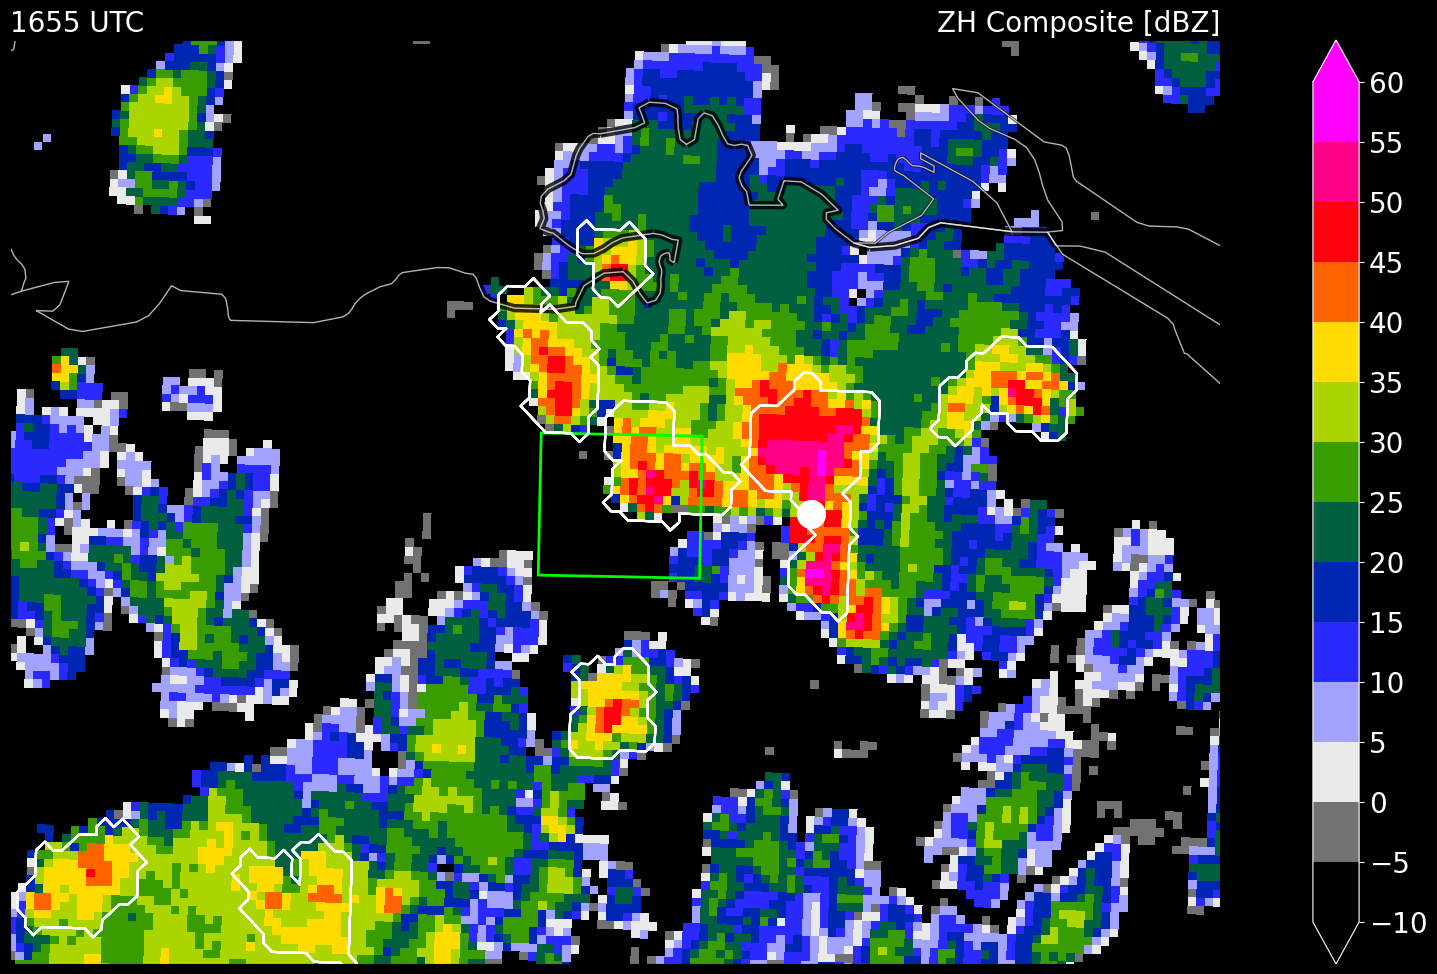

In [266]:
# Crowd-sourcing data and Max. downdraft estimator w
# Multi-variable plot
projection = ccrs.epsg(3035)
# Create figure with three subplots (Reflectivity, Velocity, and Dealiased Velocity)
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': projection})


fig.patch.set_facecolor('black')  # Set figure background
ax.set_facecolor('black')  # Set axis background
edgecolor = 'white'


# Plot wge composite
# Set a mask

cmap_czc.set_bad(color='grey')
p12 = ax.pcolormesh(clons, clats, czc, 
                   cmap=cmap_czc, transform=projection, norm=czc_norm)
# Add a colorbar
cbar12 = plt.colorbar(p12, ax=ax, extend='both', cmap=cmap_czc, norm=czc_norm, boundaries=czc_levels, ticks=czc_levels)
cbar12.outline.set_edgecolor(edgecolor)
cbar12.ax.yaxis.set_tick_params(color=edgecolor)
plt.setp(plt.getp(cbar12.ax.axes, 'yticklabels'), color=edgecolor, fontsize = 20)
ax.set_title('ZH Composite [dBZ]', color=edgecolor, loc='right', fontsize=20)
ax.set_title(valid_time3 + ' UTC', color=edgecolor, loc='left', fontsize=20)
ax.set_extent(Zurich_extent, crs=ccrs.PlateCarree())
 # Add borders, coastlines, and lakes with custom contour lines
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=6)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.8, linewidth=2)
ax.add_feature(cfeature.BORDERS, edgecolor='white', linestyle='-', alpha=0.7)
ax.add_feature(cfeature.COASTLINE, edgecolor='white', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='white', facecolor='none', alpha=0.7)

        
ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), colors='white', alpha=1, transform=ccrs.PlateCarree())


# Create a Rectangle patch
zurich_rect = patches.Rectangle(
    (zurich_coords[0][0], zurich_coords[0][1]),
    zurich_coords[2][0] - zurich_coords[0][0],
    zurich_coords[2][1] - zurich_coords[0][1],
    linewidth=2,
    edgecolor='lime',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(zurich_rect)





# Load the JSON file
with open(file_cs, 'r') as file:
    data = json.load(file)

# Convert timestamp to datetime
def convert_timestamp(ms):
    return datetime.utcfromtimestamp(ms / 1000)



valid_time3_with_colon = f"{valid_time3[:2]}:{valid_time3[2:]}"  # Add colon to valid_time3

# Convert valid_time3 to a datetime object
valid_time3_datetime = datetime.strptime(f'2023-08-04 {valid_time3_with_colon}', '%Y-%m-%d %H:%M')

# Calculate valid_time as 2 hours before valid_time3
valid_time = valid_time3_datetime - timedelta(hours=2)

# Format valid_time as a string with the desired format
valid_time_str = valid_time.strftime('%Y-%m-%d %H:%M:%S')

print(f"valid_time3: {valid_time3_with_colon}")
print(f"valid_time: {valid_time_str}")


# Set the valid time and time range
time_range = timedelta(minutes=2.5)

# Filter features within the time range
filtered_features = [
    feature for feature in data
    if abs(convert_timestamp(feature['properties']['timestamp']) - valid_time) <= time_range
]

# Plot the features
for feature in filtered_features:
    lon, lat = feature['geometry']['coordinates']
    ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=20, color='white')
    print(lon, lat)


# Save the figure
#plt.savefig("/users/fackerma/newproject1/figures/sixth_case/CS2/CS2_" + valid_time3 + ".png", dpi=300)

valid_time3: 16:50
valid_time: 2023-08-04 14:50:00


/tmp/ipykernel_137978/4088277544.py:33: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(ms / 1000)


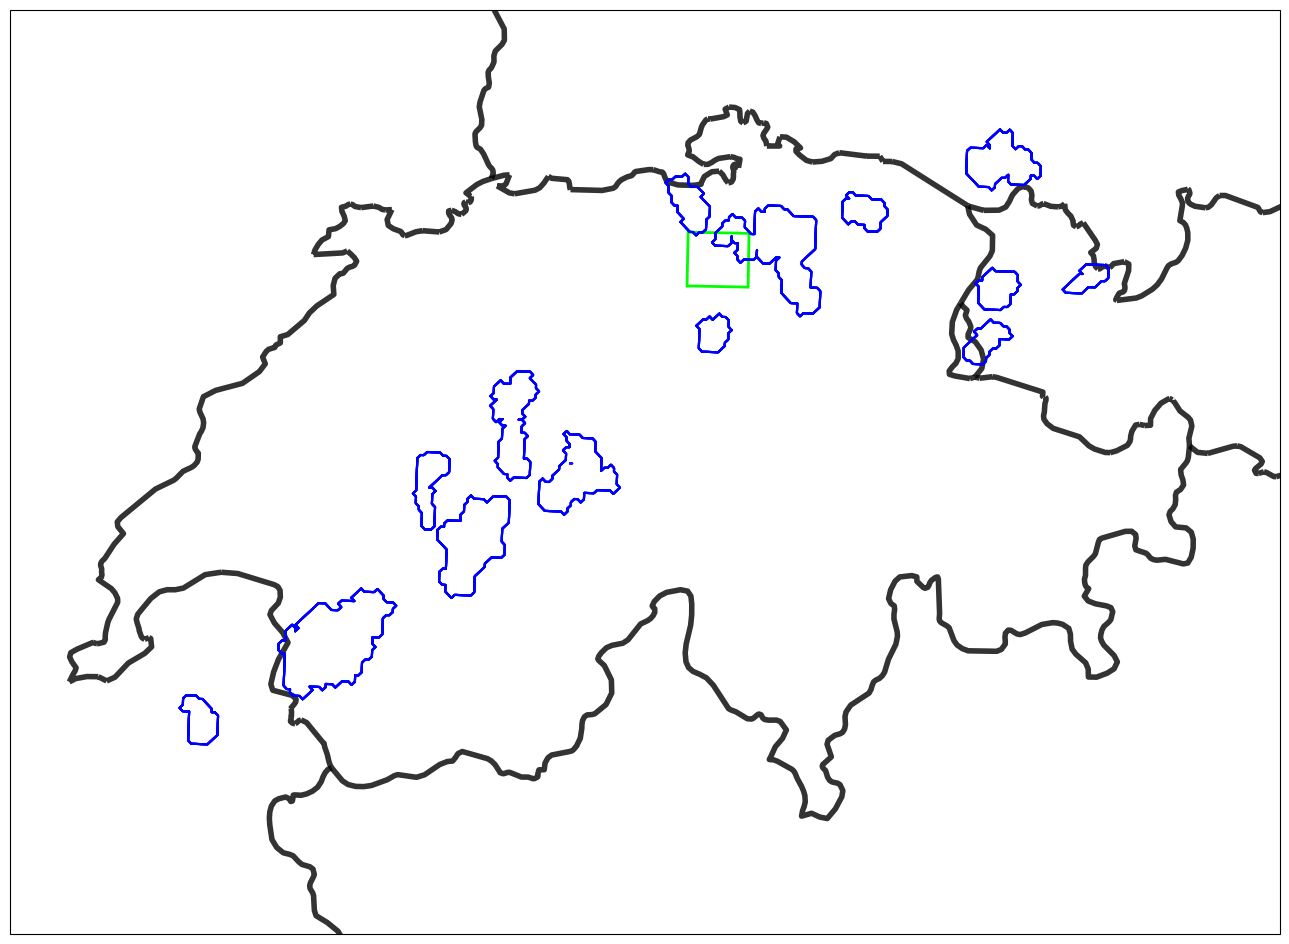

In [271]:
# Set up the plot (assuming you've already created the figure and axis)
projection = ccrs.epsg(3035)
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': projection})


valid_time4 = valid_time3 + '0'
path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/negative_cases/case_040823/"}  # Replace with your actual path
trt_df, cells_list, timelist = read_TRT(path_trtc, ttime=valid_time4)
# Extract the first element from the list of cells
cells = cells_list[0]
# Define Swiss CH1903 to WGS84 transformer
transformer_trtc = Transformer.from_crs("epsg:21781", "epsg:4326", always_xy=True)
# Grid dimensions and origin
o_x, o_y = 255000, -160000  # Origin in Swiss coordinates
lx, ly = 710, 640           # Grid size (width x height)
cell_size = 1000            # 1 km grid spacing
# Create Swiss grid (CH1903 coordinates)
x_coords = np.linspace(o_x, o_x + (lx - 1) * cell_size, lx)
y_coords = np.linspace(o_y, o_y + (ly - 1) * cell_size, ly)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
# Convert grid to WGS84 (longitude, latitude)
lon_trtc, lat_trtc = transformer_trtc.transform(x_grid, y_grid)




# Load the JSON file
with open(file_cs, 'r') as file:
    data = json.load(file)

# Convert timestamp to datetime
def convert_timestamp(ms):
    return datetime.utcfromtimestamp(ms / 1000)



valid_time3_with_colon = f"{valid_time3[:2]}:{valid_time3[2:]}"  # Add colon to valid_time3

# Convert valid_time3 to a datetime object
valid_time3_datetime = datetime.strptime(f'2023-08-04 {valid_time3_with_colon}', '%Y-%m-%d %H:%M')

# Calculate valid_time as 2 hours before valid_time3
valid_time = valid_time3_datetime - timedelta(hours=2)

# Format valid_time as a string with the desired format
valid_time_str = valid_time.strftime('%Y-%m-%d %H:%M:%S')

print(f"valid_time3: {valid_time3_with_colon}")
print(f"valid_time: {valid_time_str}")


# Set the valid time and time range
time_range = timedelta(minutes=2.5)

# Filter features within the time range
filtered_features = [
    feature for feature in data
    if abs(convert_timestamp(feature['properties']['timestamp']) - valid_time) <= time_range
]

# Plot the features
for feature in filtered_features:
    lon, lat = feature['geometry']['coordinates']
    ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree(), markersize=5, color='red')
    print(lon, lat)


# Add coastlines and borders for reference
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.8, linewidth=4)

# Set the extent of the map (adjust as needed)
ax.set_extent(extent_switzerland, crs=ccrs.PlateCarree())

# Create a Rectangle patch
zurich_rect = patches.Rectangle(
    (zurich_coords[0][0], zurich_coords[0][1]),
    zurich_coords[2][0] - zurich_coords[0][0],
    zurich_coords[2][1] - zurich_coords[0][1],
    linewidth=2,
    edgecolor='lime',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(zurich_rect)

ax.contour(lon_trtc, lat_trtc, cells, levels=np.arange(0, 11), colors='blue', alpha=0.7, transform=ccrs.PlateCarree())

# Save the figure
plt.savefig("/users/fackerma/newproject1/figures/negative_cases/" + valid_time3 + "_Cells_CS.png", dpi=300, bbox_inches='tight')


## TRTC

## Negative Cases

In [3]:

df = pd.read_pickle("/scratch/mch/fackerma/orders/Gust_Markers/Gust_Markers_3.pkl")


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon

#zurich_coords = [
#    (8.4, 47.3),
#    (8.4, 47.45),
#    (8.65, 47.45),
#    (8.65, 47.3)
#]

#zurich_coords = [
 #   (8.527, 47.331),
 #   (8.583, 47.352),
#    (8.550, 47.395),
#    (8.567, 47.402),
#    (8.617, 47.385),
#    (8.639, 47.401),
#    (8.542, 47.433),
#    (8.488, 47.425),
#    (8.455, 47.398)
#]



zurich_polygon = Polygon(zurich_coords)
zurich_gdf = gpd.GeoDataFrame({'geometry': [zurich_polygon]}, crs="EPSG:4326")



# Create geometry column
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


zurich_wind_gusts = gpd.sjoin(gdf, zurich_gdf, how="inner", predicate="within")


In [5]:
# Create a date range from 2019 to 2023
all_dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')

# Get unique dates with wind gust markers in Zurich
zurich_wind_dates = zurich_wind_gusts['Time'].dt.date.unique()

# Find dates without wind gust markers
dates_without_gusts = set(all_dates.date) - set(zurich_wind_dates)

# Sort the dates
dates_without_gusts = sorted(list(dates_without_gusts))


In [6]:
print(f"Number of days without wind gust markers in Zurich: {len(dates_without_gusts)}")
print(f"Number of days with wind gust markers in Zurich: {len(zurich_wind_dates)}")


Number of days without wind gust markers in Zurich: 504
Number of days with wind gust markers in Zurich: 259


In [7]:
from datetime import datetime

def check_date_without_gusts(input_date):
    # Convert input string to date object
    try:
        check_date = datetime.strptime(input_date, "%Y-%m-%d").date()
    except ValueError:
        return "Invalid date format. Please use YYYY-MM-DD."

    # Check if the date is within the range of all_dates
    if check_date < all_dates[0].date() or check_date > all_dates[-1].date():
        return f"The date {input_date} is outside the range of {all_dates[0].date()} to {all_dates[-1].date()}."

    # Check if the date is in dates_without_gusts
    if check_date in dates_without_gusts:
        return f"No gust on {input_date}."
    else:
        return f"Gust on {input_date}."




In [8]:
check_date_without_gusts('2023-07-27')

'No gust on 2023-07-27.'

New bounds: West: 5.904191012734619, South: 45.780250744858265, East: 10.562547746600194, North: 47.8145202229546


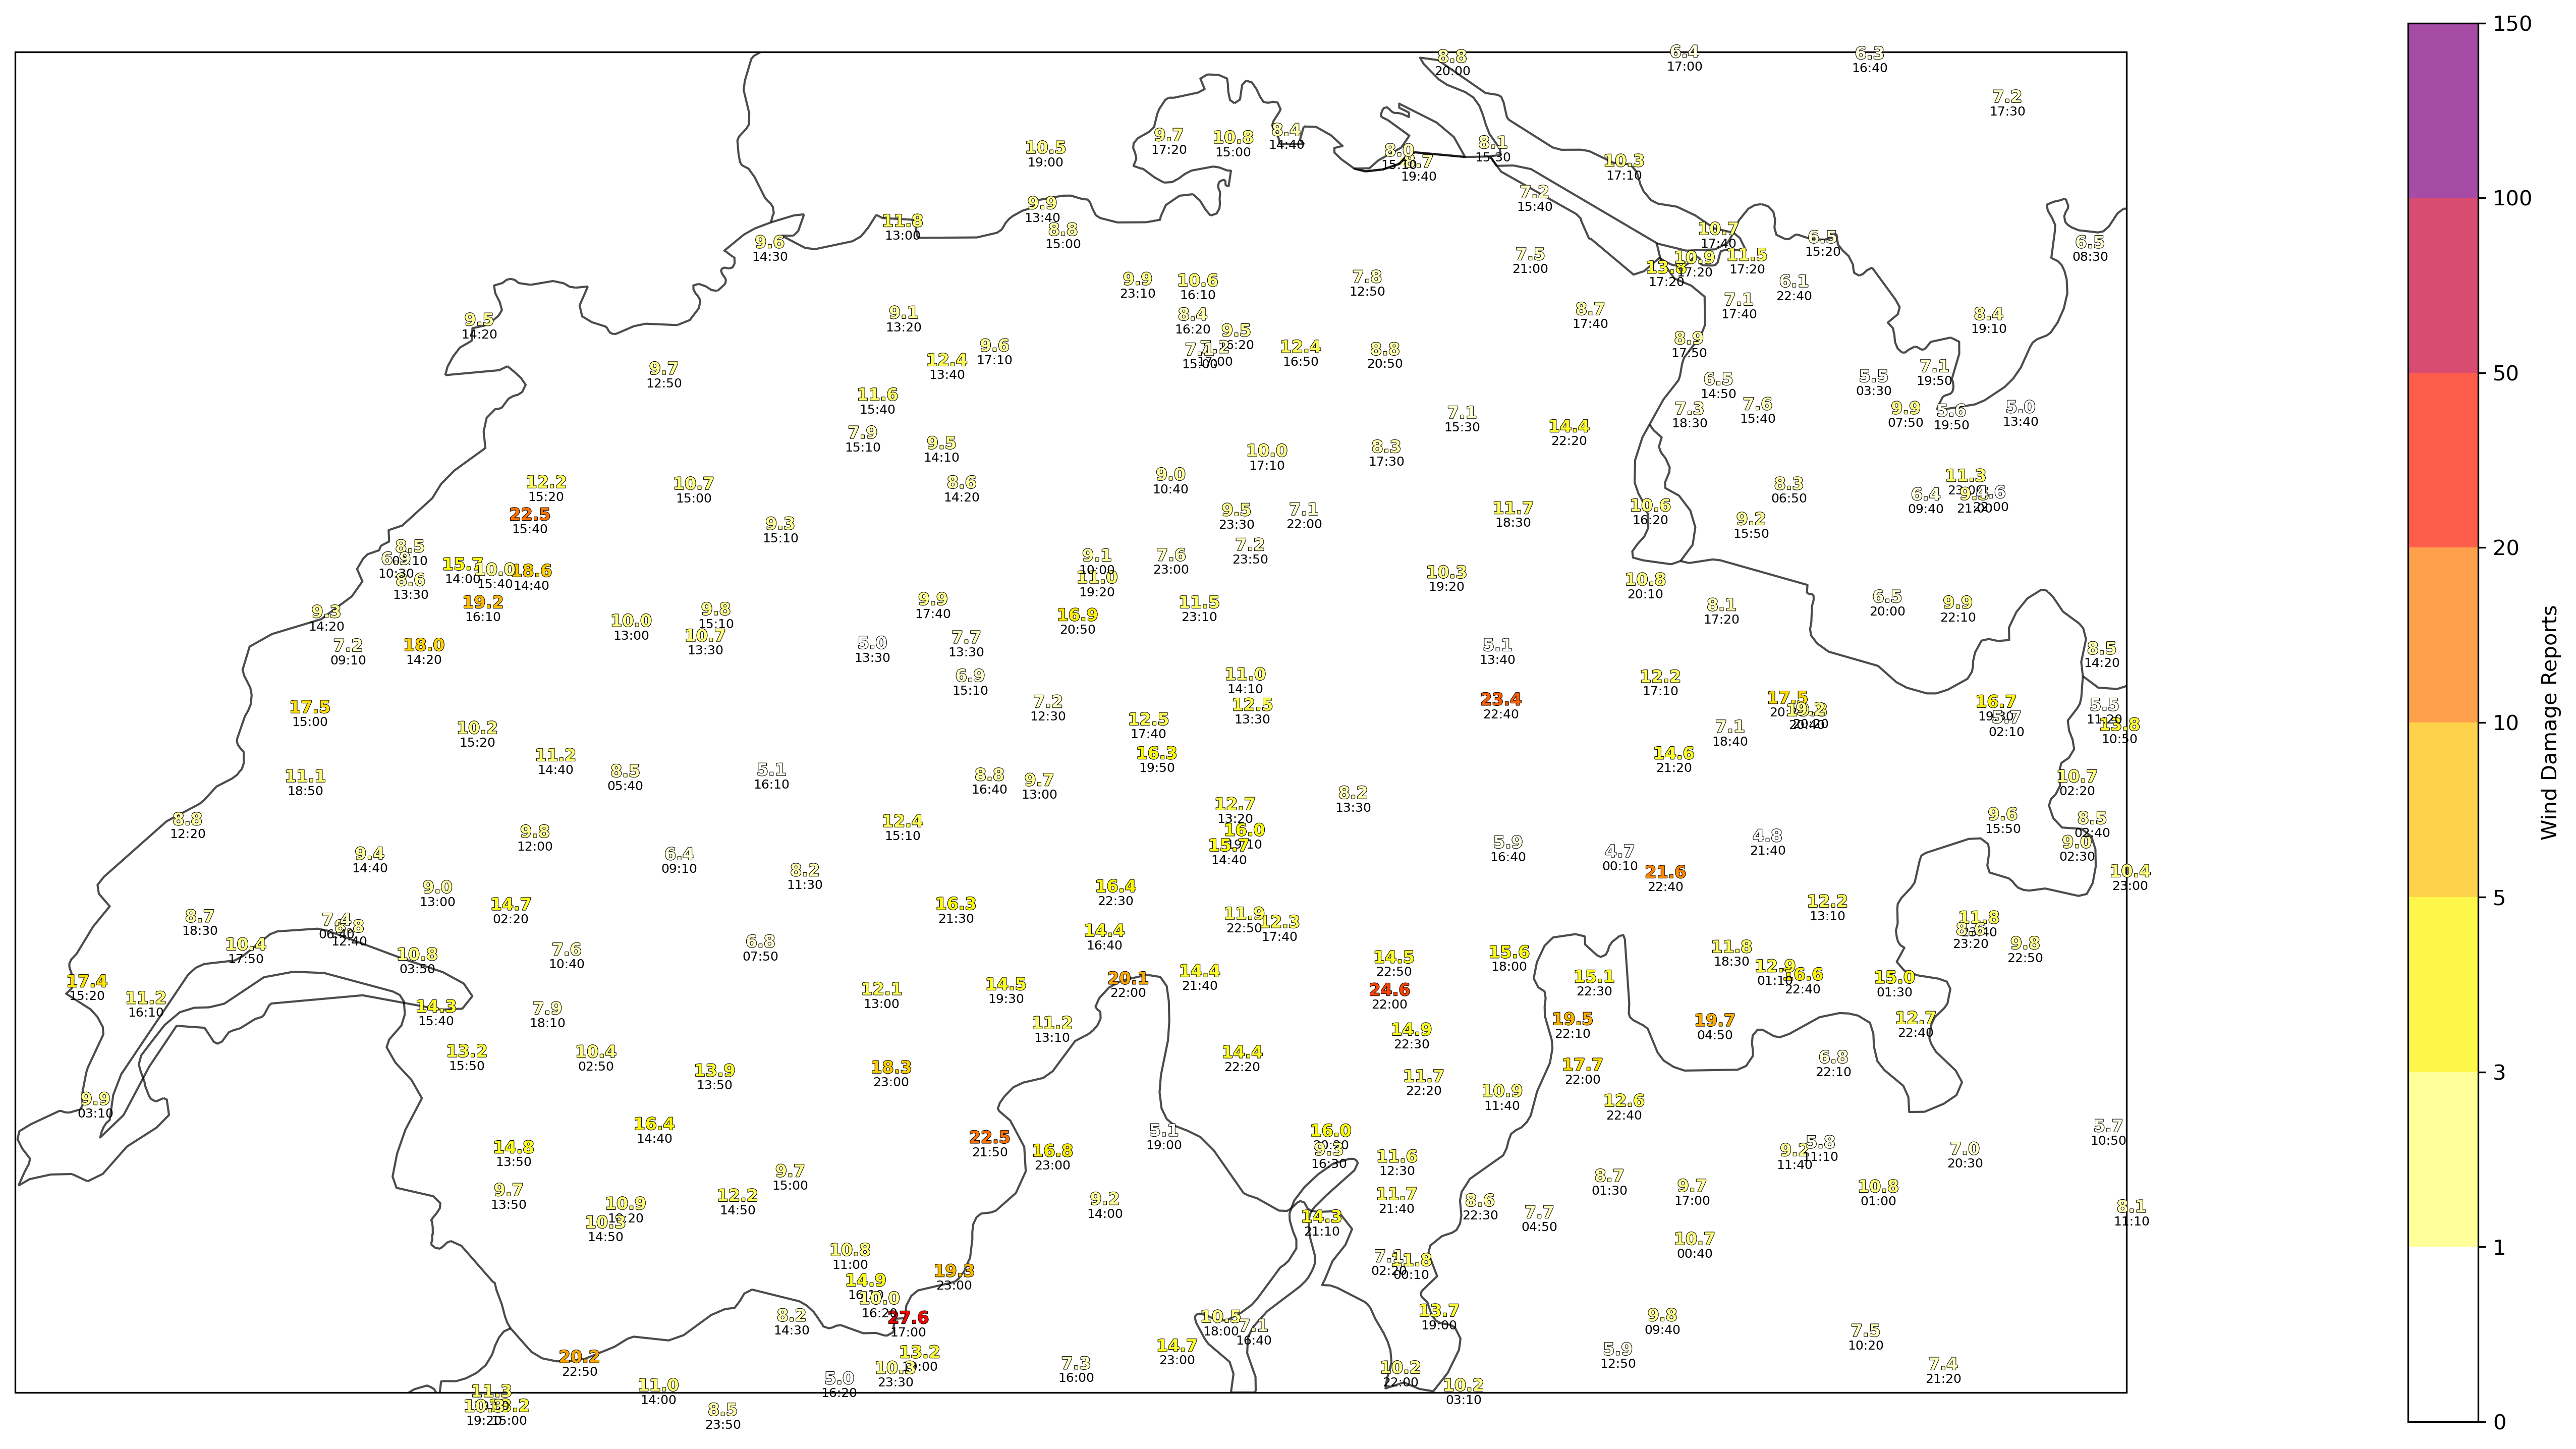

In [ ]:


# Set the projection to WGS84
projection = ccrs.epsg(2056)

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(24, 12), subplot_kw={'projection': projection}, dpi=300)

# Set background to white for the plot
fig.patch.set_facecolor('white')
ax.set_facecolor('white')


schaden_levels = np.array([0, 1, 3, 5, 10, 20, 50, 100, 150])
schaden_norm= BoundaryNorm(boundaries=schaden_levels, ncolors=256, clip=True)
cmap_schaden = LinearSegmentedColormap.from_list("custom_cmap", ["white","yellow", "orange", "red","purple"], N=256)



# Define the path and open the GeoTIFF file
path = "/scratch/mch/fackerma/orders/Schadendaten/"
target_date = "20230804"
file_name = f"Schaeden_{target_date}_Sturmwind.tif"
file_path = os.path.join(path, file_name)

with rasterio.open(file_path) as src:
    # Define target CRS
    dst_crs = 'EPSG:4326'

    # Calculate the optimal resolution and transformation parameters
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    # Create a new array to store the reprojected data
    reprojected_data = np.zeros((height, width), dtype=src.dtypes[0])

    # Reproject the data
    reproject(
        source=rasterio.band(src, 1),
        destination=reprojected_data,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    # Mask nodata values
    reprojected_data = np.ma.masked_equal(reprojected_data, src.nodata)

    # Calculate new bounds
    west, south, east, north = rasterio.transform.array_bounds(height, width, transform)

    # Plot the reprojected raster data
    img = ax.imshow(reprojected_data, extent=(west, east, south, north), 
                    transform=ccrs.PlateCarree(), cmap=cmap_schaden, norm=schaden_norm ,alpha=0.7)

# Add colorbar for the raster data
cbar = plt.colorbar(img, ax=ax, label="Wind Damage Reports", pad=0.1, cmap=cmap_schaden, norm=schaden_norm, boundaries=schaden_levels, ticks=schaden_levels)


# Set the extent of the map to Switzerland (you may need to adjust these values)
ax.set_extent([5.9, 10.5, 45.8, 47.8], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle='-', alpha=0.7)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', alpha=0.7)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', alpha=0.7)


# Scan the parquet files
df = pl.scan_parquet('/scratch/mch/fackerma/orders/station_data/0_raw/data/**/*.parquet', hive_partitioning=True)

from datetime import datetime
# Filter for the target date and 'fkl010z1' parameter
target_date = datetime(2023, 8, 4, tzinfo=timezone.utc)
df_filtered = df.filter(
    (pl.col('datetime').dt.date() == target_date.date()) &
    (pl.col('param_short') == 'fkl010z1')
)

# Collect the filtered data
df_eager = df_filtered.collect()

# Find the maximum wind gust for each station
max_wind_by_station = df_eager.group_by('station_id').agg([
    pl.col('value').max().alias('max_wind_gust'),
    pl.col('latitude').first().alias('latitude'),
    pl.col('longitude').first().alias('longitude'),
    pl.col('nat_abbr').first().alias('station_abbr'),
    pl.col('datetime').filter(pl.col('value') == pl.col('value').max()).first().alias('max_gust_time')
])

# Sort by max_wind_gust in descending order
max_wind_by_station = max_wind_by_station.sort('max_wind_gust', descending=True)

# Filter data to include only points within the extent
filtered_data = max_wind_by_station.filter(
    (pl.col('longitude') >= west) & 
    (pl.col('longitude') <= east) & 
    (pl.col('latitude') >= south) & 
    (pl.col('latitude') <= north)
)

# Create a custom colormap (white to yellow to red)
colors = ['white', 'yellow', 'red']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Normalize wind gust values for color mapping
min_gust = filtered_data['max_wind_gust'].min()
max_gust = filtered_data['max_wind_gust'].max()
norm = plt.Normalize(min_gust, max_gust)

# Plot the wind gust values
for row in filtered_data.iter_rows(named=True):
    # Plot max wind gust value
    text = ax.text(
        row['longitude'], row['latitude'], 
        f"{row['max_wind_gust']:.1f}",
        fontsize=8, fontweight='bold', 
        color=cmap(norm(row['max_wind_gust'])),
        ha='center', va='bottom', transform=ccrs.PlateCarree()
    )
    # Add black contour to the text
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='black'),
                           path_effects.Normal()])
    
    # Plot UTC time
    utc_time = row['max_gust_time'].strftime('%H:%M')
    ax.text(
        row['longitude'], row['latitude'], 
        utc_time,
        fontsize=6, color='black',
        ha='center', va='top', transform=ccrs.PlateCarree()
    )


# Print the new bounds for verification
print(f"New bounds: West: {west}, South: {south}, East: {east}, North: {north}")

#plt.savefig("/users/fackerma/newproject1/figures/negative_cases/" + day + "_windschaden_stationen.png", dpi=300, bbox_inches='tight')

## TRT Flagging

In [ ]:
# Flagging with negative, spatial prio and 5 / 10 km Buffer

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import os
import datetime
from datetime import datetime, timedelta



# Change definition based on path fot trt files
def process_gust_markers(valid_date3, valid_time3):
    # Convert time format and read TRT data
    valid_time4 = valid_time3 + '0'
    path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/negative_cases/case_040823/"}  
    trt_df, cells_list, timelist = read_TRT(path_trtc, ttime=valid_time4)

    # Load the Gust Markers dataframe
    df = pd.read_pickle("/scratch/mch/fackerma/orders/Gust_Markers/Gust_Markers_3.pkl")

    # Check if trt_df is empty
    if trt_df.empty:
        # Create an empty DataFrame with the required columns
        empty_df = pd.DataFrame(columns=['CS Marker', 'STA Marker', 'Gust_Flag'])
        return empty_df, pd.DataFrame(), gpd.GeoDataFrame(), gpd.GeoDataFrame(), gpd.GeoDataFrame()
    
    zurich_coords = [(8.4, 47.3),(8.4, 47.45),(8.65, 47.45),(8.65, 47.3)]

    # Create a Polygon from the coordinates
    zurich_polygon = Polygon(zurich_coords)

    # Create a GeoDataFrame with the polygon
    zurich_gdf = gpd.GeoDataFrame({'name': ['Zurich']}, geometry=[zurich_polygon], crs="EPSG:4326")


    # Convert trt_df to a GeoDataFrame and create buffer
    trt_gdf = GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")
    trt_gdf_projected = trt_gdf.to_crs(epsg=32632)
    trt_gdf_projected['buffer_geometry'] = trt_gdf_projected.geometry.buffer(10000)
    trt_gdf_with_buffer = trt_gdf_projected.to_crs(epsg=4326)
    trt_gdf_with_buffer['buffer_geometry'] = trt_gdf_with_buffer['buffer_geometry'].to_crs(epsg=4326)

    trt_gdf_small_buffer = trt_gdf.to_crs(epsg=32632)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer.geometry.buffer(5000)
    trt_gdf_small_buffer = trt_gdf_small_buffer.to_crs(epsg=4326)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer['buffer_geometry'].to_crs(epsg=4326)

    # Set up datetime for filtering
    datetime_string = f"{valid_date3} {valid_time3[:2]}:{valid_time3[2:]}:00"
    target_datetime = pd.to_datetime(datetime_string)
    time_window_cs = pd.Timedelta(minutes=2.5)
    time_window_sta = pd.Timedelta(minutes=5)

    # Filter and process CS and STA data
    df_cs = df[df['Source'] == 'CS']
    df_sta = df[df['Source'] == 'STA'].copy()
    df_sta['Time'] = df_sta['Time'] - pd.Timedelta(minutes=5)

    filtered_df_cs = df_cs[(df_cs['Time'] >= target_datetime - time_window_cs) & 
                           (df_cs['Time'] <= target_datetime + time_window_cs)]
    filtered_df_sta = df_sta[(df_sta['Time'] >= target_datetime - time_window_sta) & 
                             (df_sta['Time'] <= target_datetime + time_window_sta)]

    # Convert to GeoDataFrames
    gust_gdf_cs = GeoDataFrame(filtered_df_cs, 
                               geometry=gpd.points_from_xy(filtered_df_cs.Longitude, filtered_df_cs.Latitude),
                               crs="EPSG:4326")
    gust_gdf_sta = GeoDataFrame(filtered_df_sta, 
                                geometry=gpd.points_from_xy(filtered_df_sta.Longitude, filtered_df_sta.Latitude),
                                crs="EPSG:4326")

    # Perform spatial joins for CS gusts
    trt_gdf_buffer = trt_gdf_with_buffer.copy()
    trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
    trt_gdf_small_buffer.set_geometry('buffer_geometry', inplace=True)
    matched_gusts_cs = gpd.sjoin(gust_gdf_cs, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')

    # For STA gusts, find the closest cell
    def find_closest_cell(gust_point, cells_gdf):
        distances = cells_gdf.geometry.distance(gust_point)
        closest_cell_index = distances.idxmin()
        return closest_cell_index, distances[closest_cell_index]

    sta_closest_cells = matched_gusts_sta.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))
    cs_closest_cells = matched_gusts_cs.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))

    # Convert to DataFrame and remove duplicates
    sta_closest_df = pd.DataFrame(sta_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=sta_closest_cells.index)
    sta_closest_df = sta_closest_df.drop_duplicates(subset=['traj_ID', 'distance'])

    cs_closest_df = pd.DataFrame(cs_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=cs_closest_cells.index)
    cs_closest_df = cs_closest_df.drop_duplicates(subset=['traj_ID', 'distance'])

    # Process CS gusts (using spatial join results)
    #cs_counts = matched_gusts_cs['traj_ID'].value_counts()

    # Process STA gusts (using closest cell approach)
    cs_counts = {}
    for index, row in cs_closest_df.iterrows():
        if row['distance'] <= 5000:  # Only consider gusts within 10km
            cs_counts[row['traj_ID']] = cs_counts.get(row['traj_ID'], 0) + 1

    # Process STA gusts (using closest cell approach)
    sta_counts = {}
    for index, row in sta_closest_df.iterrows():
        if row['distance'] <= 10000:  # Only consider gusts within 10km
            sta_counts[row['traj_ID']] = sta_counts.get(row['traj_ID'], 0) + 1

    # Update trt_df with the new counts
    #trt_df['CS Marker'] = trt_df['traj_ID'].map(cs_counts).fillna(0).astype(int)
    trt_df['CS Marker'] = trt_df.index.map(lambda x: cs_counts.get(x, 0)).fillna(0).astype(int)
    trt_df['STA Marker'] = trt_df.index.map(lambda x: sta_counts.get(x, 0)).fillna(0).astype(int)

    # Check if TRT cell buffer touches Zurich polygon
    #touches_zurich = trt_gdf_buffer.buffer_geometry.intersects(zurich_gdf.geometry.iloc[0])
    touches_zurich = trt_gdf.intersects(zurich_gdf.geometry.iloc[0])
    
    # Assign 'Gust_Flag' based on the new condition
    trt_df['Gust_Flag'] = np.where(
        (trt_df['CS Marker'] > 0) | (trt_df['STA Marker'] > 0),
        'Yes',
        np.where(
            (touches_zurich) &
            (target_datetime.time() >= datetime.strptime("04:00:00", "%H:%M:%S").time()) &
            (target_datetime.time() <= datetime.strptime("20:00:00", "%H:%M:%S").time()) &
            (target_datetime.year in [2022, 2023]),  # Check if the year is 2022 or 2023
            'No',
            '-'
        )
    )

    # Combine matched_gusts_cs with closest STA gusts for consistency
    sta_closest_df = pd.DataFrame(sta_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=matched_gusts_sta.index)
    sta_closest_df = sta_closest_df[sta_closest_df['distance'] <= 10000]
    matched_gusts_sta = gust_gdf_sta.loc[sta_closest_df.index].copy()
    matched_gusts_sta['traj_ID'] = sta_closest_df['traj_ID']
    matched_gusts = pd.concat([matched_gusts_cs, matched_gusts_sta])

    return trt_df, matched_gusts, gust_gdf_cs, gust_gdf_sta, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, trt_gdf, target_datetime, sta_closest_df, sta_closest_cells, zurich_gdf, touches_zurich, trt_gdf_small_buffer



In [ ]:
# Process the trt files

valid_date3 = '2023-08-04'
start_time = datetime.strptime('0000', '%H%M').time()
end_time = datetime.strptime('2355', '%H%M').time()
time_delta = timedelta(minutes=5)

current_time = datetime.combine(datetime.min, start_time)
while current_time.time() <= end_time:
    valid_time3 = current_time.strftime('%H%M')
    print(f"Processing for time: {valid_time3}")
    
    trt_df, matched_gusts, gust_gdf_cs, gust_gdf_sta = process_gust_markers(valid_date3, valid_time3)

    # Generate the filename
    filename = f'trt_df_{valid_date3}_{valid_time3}.pkl'

    # Save the DataFrame (empty or not)
    trt_df.to_pickle(f'/scratch/mch/fackerma/orders/trt_df_testset1/{filename}')
    
    if valid_time3 == '2355':
        break

    current_time += time_delta

print("Processing complete for all times.")

In [ ]:
# Process a trt_df file
valid_date3 = '2023-08-04'
valid_time3 = '1430'
day = '23216'

trt_df, matched_gusts, gust_gdf_cs, gust_gdf_sta, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, trt_gdf, target_datetime, sta_closest_df, sta_closest_cells, zurich_gdf, touches_zurich, trt_gdf_small_buffer = process_gust_markers(valid_date3, valid_time3)


/tmp/ipykernel_31020/2311365253.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = cells_gdf.geometry.distance(gust_point)
/tmp/ipykernel_31020/2311365253.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = cells_gdf.geometry.distance(gust_point)


## Inspect TRT Flagging

/tmp/ipykernel_31020/3860752802.py:27: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  trt_gdf_buffer.plot(ax=ax, column='buffer_geometry', color='white', alpha=0.3, label='10km Buffer', edgecolor='black')
/tmp/ipykernel_31020/3860752802.py:30: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  trt_gdf_small_buffer.plot(ax=ax, column='buffer_geometry', color='yellow', alpha=0.3, label='5km Buffer', edgecolor='black')
/tmp/ipykernel_31020/3860752802.py:56: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper left', fontsize=12)


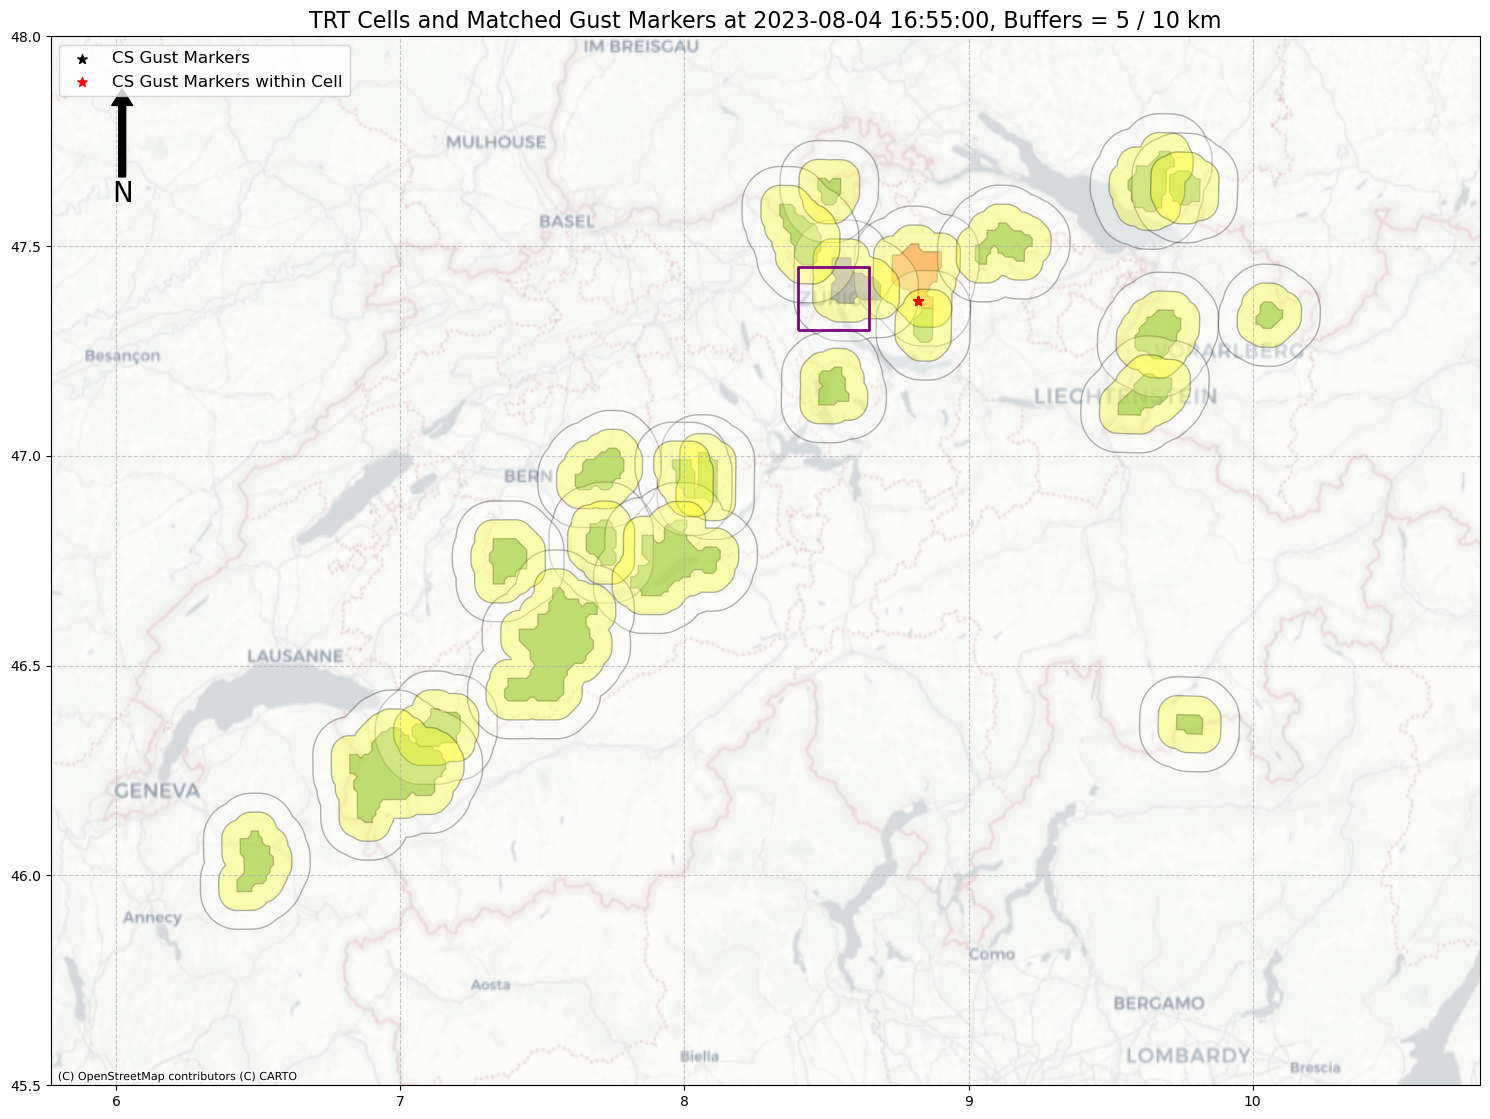

In [45]:
import matplotlib.pyplot as plt
import contextily as ctx
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 15))


# Set the spatial extent
extent = extent_switzerland
#extent = Zurich_extent
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

# Plot the original TRT cell geometries
#trt_gdf_with_buffer.plot(ax=ax, color='green', edgecolor='black', linewidth=1, label='TRT Cells', alpha=0.5)

# Convert trt_df to GeoDataFrame
trt_gdf_new = gpd.GeoDataFrame(trt_df, geometry='geometry')

# Plot the TRT cells with conditional coloring
trt_gdf_new.plot(ax=ax, color=trt_gdf_new['Gust_Flag'].map({'Yes': 'red', '-': 'green', 'No': 'blue'}), 
             edgecolor='black', linewidth=1, label='TRT Cells', alpha=0.5)

# Plot the buffer geometries
trt_gdf_buffer.plot(ax=ax, column='buffer_geometry', color='white', alpha=0.3, label='10km Buffer', edgecolor='black')

# Plot the buffer geometries
trt_gdf_small_buffer.plot(ax=ax, column='buffer_geometry', color='yellow', alpha=0.3, label='5km Buffer', edgecolor='black')

# Plot CS gust markers if not empty
if not gust_gdf_cs.empty:
    gust_gdf_cs.plot(ax=ax, color='black', markersize=50, label='CS Gust Markers', marker='*')

# Plot STA gust markers if not empty
if not gust_gdf_sta.empty:
    gust_gdf_sta.plot(ax=ax, color='black', markersize=40, label='STA Gust Markers', marker='o')

# Plot matched CS gust markers if not empty
if not matched_gusts_cs.empty:
    matched_gusts_cs.plot(ax=ax, color='red', markersize=50, label='CS Gust Markers within Cell', marker='*')

# Plot matched STA gust markers if not empty
if not matched_gusts_sta.empty:
    matched_gusts_sta.plot(ax=ax, color='blue', markersize=40, label='STA Gust Markers within 10km Buffer', marker='o')

# Plot the Zurich polygon
zurich_gdf.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=2, label='Zurich Area')

# Add a basemap
ctx.add_basemap(ax, crs=trt_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add title and legend
plt.title(f"TRT Cells and Matched Gust Markers at {target_datetime}, Buffers = 5 / 10 km", fontsize=16)
plt.legend(loc='upper left', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Add north arrow
x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Show the plot
plt.tight_layout()

#plt.savefig("/users/fackerma/newproject1/figures/negative_cases/Gust_Markers/2_" + day + '_' + valid_time3 + "_10km_spatprio_.png", dpi=300, bbox_inches='tight')


## TRT Flagging on 5 year period

In [ ]:
# Flagging with negative, spatial prio and 5 / 10 km Buffer

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import os
import datetime
from datetime import datetime, timedelta

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = int(t[0].values)
            trt_df.loc[n, 'time'] = int(t[1].values)
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            #if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist

def process_gust_markers(valid_date3, valid_time3):
    # Convert time format and read TRT data
    # Convert valid_date3 to a datetime object
    date_obj = datetime.strptime(valid_date3, '%Y-%m-%d')
    # Extract the last two digits of the year and the day of the year
    year_last_two = date_obj.strftime('%y')  # Last two digits of the year
    day_of_year = date_obj.timetuple().tm_yday  # Day of the year (1-366)
    # Combine them into the desired format
    valid_date4 = f"{year_last_two}{day_of_year:03d}"  # Ensure day_of_year is zero-padded to 3 digits
    valid_time4 = valid_time3 + '0'
    path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/TRT_set"}  
    trt_df, cells_list, timelist = read_TRT(path_trtc, ttime=valid_date4+valid_time4)

    # Load the Gust Markers dataframe
    df = pd.read_pickle("/scratch/mch/fackerma/orders/Gust_Markers/Gust_Markers_3.pkl")

    # Check if trt_df is empty
    if trt_df.empty:
        # Create an empty DataFrame with the required columns
        empty_df = pd.DataFrame(columns=['geometry', 'CS Marker', 'STA Marker', 'ESWD Marker', 'Gust_Flag'])
        trt_df = empty_df.copy()
        return trt_df
    else:
        zurich_coords = [(8.4, 47.3), (8.4, 47.45), (8.65, 47.45), (8.65, 47.3)]

        # Create a Polygon from the coordinates
        zurich_polygon = Polygon(zurich_coords)

        # Create a GeoDataFrame with the polygon
        zurich_gdf = gpd.GeoDataFrame({'name': ['Zurich']}, geometry=[zurich_polygon], crs="EPSG:4326")

        # Convert trt_df to a GeoDataFrame and create buffer
        trt_gdf = GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")
        trt_gdf_projected = trt_gdf.to_crs(epsg=32632)
        trt_gdf_projected['buffer_geometry'] = trt_gdf_projected.geometry.buffer(10000)
        trt_gdf_with_buffer = trt_gdf_projected.to_crs(epsg=4326)
        trt_gdf_with_buffer['buffer_geometry'] = trt_gdf_with_buffer['buffer_geometry'].to_crs(epsg=4326)

        trt_gdf_small_buffer = trt_gdf.to_crs(epsg=32632)
        trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer.geometry.buffer(5000)
        trt_gdf_small_buffer = trt_gdf_small_buffer.to_crs(epsg=4326)
        trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer['buffer_geometry'].to_crs(epsg=4326)

        # Set up datetime for filtering
        datetime_string = f"{valid_date3} {valid_time3[:2]}:{valid_time3[2:]}:00"
        target_datetime = pd.to_datetime(datetime_string)
        time_window_cs = pd.Timedelta(minutes=2.5)
        time_window_sta = pd.Timedelta(minutes=5)
        time_window_eswd = pd.Timedelta(minutes=2.5)

        # Filter and process CS and STA data
        df_cs = df[df['Source'] == 'CS']
        df_sta = df[df['Source'] == 'STA'].copy()
        df_sta['Time'] = df_sta['Time'] - pd.Timedelta(minutes=5)
        df_eswd = df[df['Source'] == 'ESWD']

        filtered_df_cs = df_cs[(df_cs['Time'] >= target_datetime - time_window_cs) & 
                               (df_cs['Time'] <= target_datetime + time_window_cs)]
        filtered_df_sta = df_sta[(df_sta['Time'] >= target_datetime - time_window_sta) & 
                                 (df_sta['Time'] <= target_datetime + time_window_sta)]
        filtered_df_eswd = df_eswd[(df_eswd['Time'] >= target_datetime - time_window_eswd) & 
                                 (df_eswd['Time'] <= target_datetime + time_window_eswd)]

        # Convert to GeoDataFrames
        gust_gdf_cs = GeoDataFrame(filtered_df_cs, 
                                   geometry=gpd.points_from_xy(filtered_df_cs.Longitude, filtered_df_cs.Latitude),
                                   crs="EPSG:4326")
        gust_gdf_sta = GeoDataFrame(filtered_df_sta, 
                                    geometry=gpd.points_from_xy(filtered_df_sta.Longitude, filtered_df_sta.Latitude),
                                    crs="EPSG:4326")
        gust_gdf_eswd = GeoDataFrame(filtered_df_eswd, 
                                    geometry=gpd.points_from_xy(filtered_df_eswd.Longitude, filtered_df_eswd.Latitude),
                                    crs="EPSG:4326")

        # Perform spatial joins for CS gusts
        trt_gdf_buffer = trt_gdf_with_buffer.copy()
        trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
        trt_gdf_small_buffer.set_geometry('buffer_geometry', inplace=True)
        
        matched_gusts_cs = gpd.sjoin(gust_gdf_cs, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
        matched_gusts_cs = matched_gusts_cs.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')
        
        matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
        matched_gusts_sta = matched_gusts_sta.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

        matched_gusts_eswd = gpd.sjoin(gust_gdf_eswd, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
        matched_gusts_eswd = matched_gusts_eswd.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

        # For STA gusts, find the closest cell
        def find_closest_cell(gust_point, cells_gdf):
            distances = cells_gdf.geometry.distance(gust_point)
            closest_cell_index = distances.idxmin()
            return closest_cell_index, distances[closest_cell_index]

        sta_closest_cells = matched_gusts_sta.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))
        cs_closest_cells = matched_gusts_cs.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))
        eswd_closest_cells = matched_gusts_eswd.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))

        sta_closest_df = pd.DataFrame(sta_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=sta_closest_cells.index)
        #sta_closest_df.drop_duplicates(subset=['traj_ID', 'distance'], inplace=True)
        cs_closest_df = pd.DataFrame(cs_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=cs_closest_cells.index)

        eswd_closest_df = pd.DataFrame(eswd_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=eswd_closest_cells.index)

        cs_counts = {}
        for index, row in cs_closest_df.iterrows():
            if row['distance'] <= 5000:
                cs_counts[row['traj_ID']] = cs_counts.get(row['traj_ID'], 0) + 1

        sta_counts = {}
        for index, row in sta_closest_df.iterrows():
            if row['distance'] <= 10000:
                sta_counts[row['traj_ID']] = sta_counts.get(row['traj_ID'], 0) + 1

        eswd_counts = {}
        for index, row in eswd_closest_df.iterrows():
            if row['distance'] <= 5000:
                eswd_counts[row['traj_ID']] = eswd_counts.get(row['traj_ID'], 0) + 1

        # Update trt_df with the new counts
        trt_df['CS Marker'] = trt_df.index.map(lambda x: cs_counts.get(x, 0)).fillna(0).astype(int)
        trt_df['STA Marker'] = trt_df.index.map(lambda x: sta_counts.get(x, 0)).fillna(0).astype(int)
        trt_df['ESWD Marker'] = trt_df.index.map(lambda x: eswd_counts.get(x, 0)).fillna(0).astype(int)

        touches_zurich = trt_gdf.intersects(zurich_gdf.geometry.iloc[0])
        
        # Assign 'Gust_Flag' based on conditions
        trt_df['Gust_Flag'] = np.where(
            (trt_df['CS Marker'] > 1) | (trt_df['STA Marker'] > 0) | (trt_df['ESWD Marker'] > 0),
            'Yes',
            np.where(
                (touches_zurich) &
                (target_datetime.time() >= datetime.strptime("04:00:00", "%H:%M:%S").time()) &
                (target_datetime.time() <= datetime.strptime("20:00:00", "%H:%M:%S").time()) &
                (target_datetime.year in [2022, 2023]),
                'No',
                '-'
            )
        )

    return trt_df
    #return trt_df, gust_gdf_cs, gust_gdf_sta, gust_gdf_eswd, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, matched_gusts_eswd, trt_gdf, target_datetime, sta_closest_df, sta_closest_cells, eswd_closest_df, eswd_closest_cells, zurich_gdf, touches_zurich, trt_gdf_small_buffer, cs_counts, sta_counts, eswd_counts, cs_closest_df, timelist, cs_closest_cells

In [ ]:

# Process a trt_df file
valid_date3 = '2021-08-12'
valid_time3 = '1830'

trt_df = process_gust_markers(valid_date3, valid_time3)
#trt_df, gust_gdf_cs, gust_gdf_sta, gust_gdf_eswd, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, matched_gusts_eswd, trt_gdf, target_datetime, sta_closest_df, sta_closest_cells, eswd_closest_df, eswd_closest_cells, zurich_gdf, touches_zurich, trt_gdf_small_buffer, cs_counts, sta_counts, eswd_counts, cs_closest_df, timelist, cs_closest_cells = process_gust_markers(valid_date3, valid_time3)

/tmp/ipykernel_253199/3955876240.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_253199/3955876240.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = int(t[0].values)
/tmp/ipykernel_253199/3955876240.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'time'] = int(t[1].values)
/tmp/ipykernel_253199/3955876240.py:103: DeprecationWarnin

/tmp/ipykernel_253199/2680065883.py:27: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  trt_gdf_buffer.plot(ax=ax, column='buffer_geometry', color='white', alpha=0.3, label='10km Buffer', edgecolor='black')
/tmp/ipykernel_253199/2680065883.py:30: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  trt_gdf_small_buffer.plot(ax=ax, column='buffer_geometry', color='yellow', alpha=0.3, label='5km Buffer', edgecolor='black')
/tmp/ipykernel_253199/2680065883.py:65: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper left', fontsize=12)


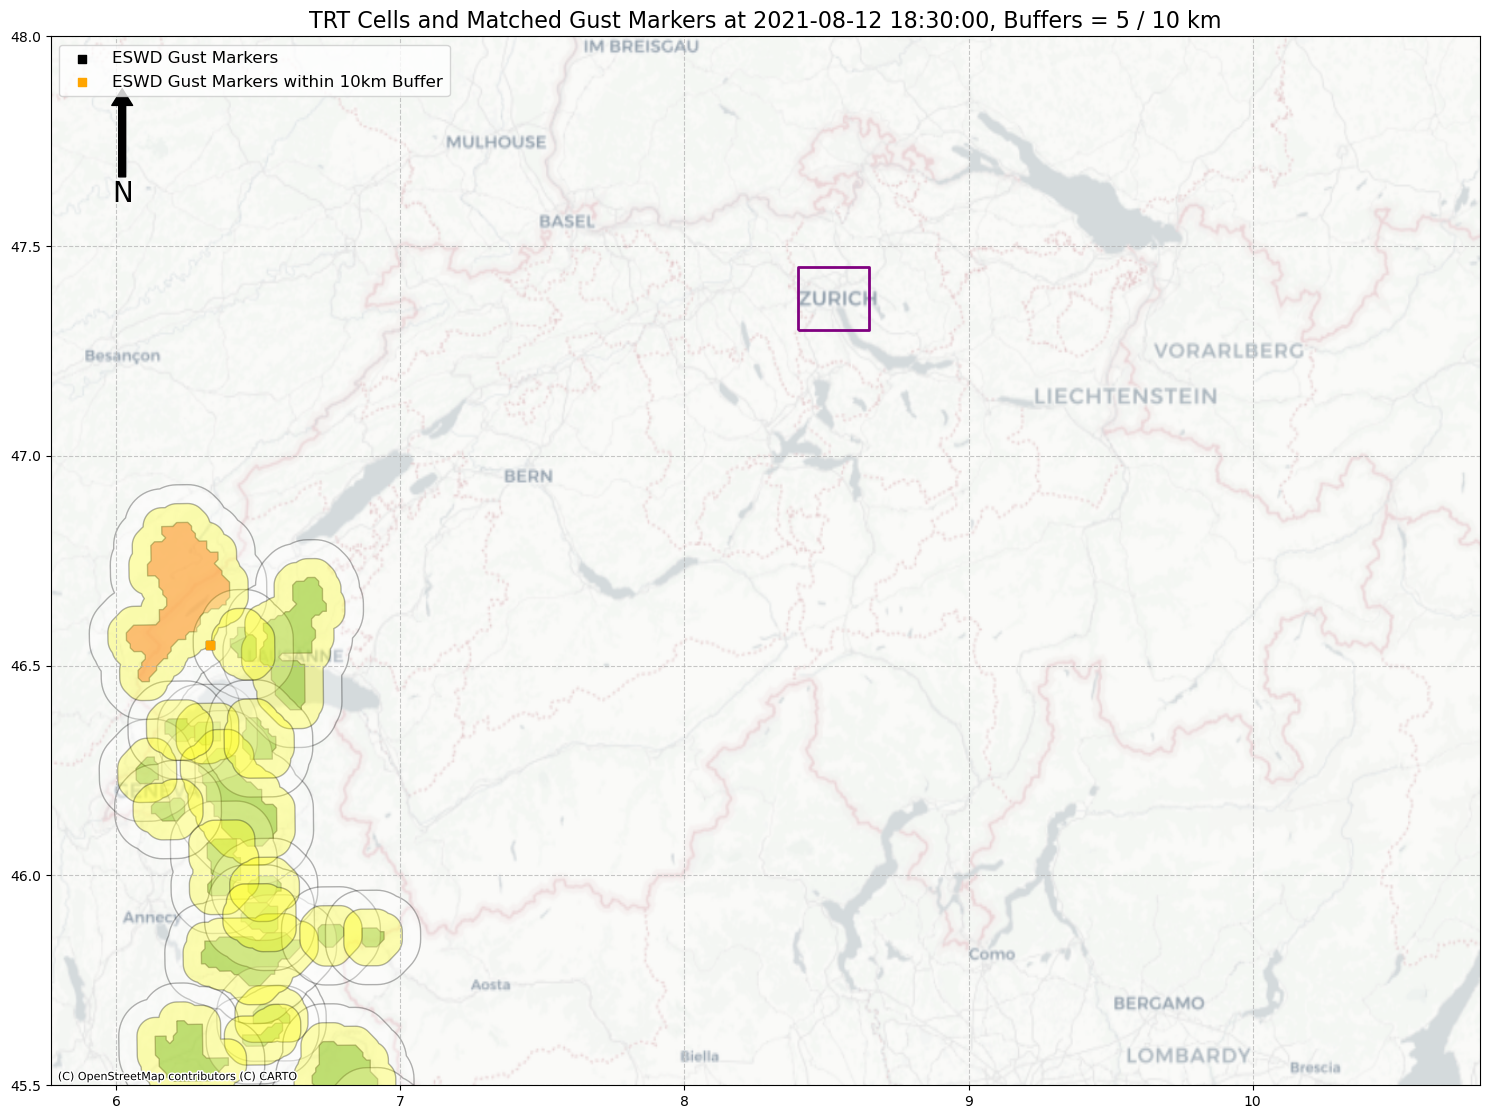

In [14]:
import matplotlib.pyplot as plt
import contextily as ctx
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 15))


# Set the spatial extent
extent = extent_switzerland
#extent = Zurich_extent
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

# Plot the original TRT cell geometries
#trt_gdf_with_buffer.plot(ax=ax, color='green', edgecolor='black', linewidth=1, label='TRT Cells', alpha=0.5)

# Convert trt_df to GeoDataFrame
trt_gdf_new = gpd.GeoDataFrame(trt_df, geometry='geometry')

# Plot the TRT cells with conditional coloring
trt_gdf_new.plot(ax=ax, color=trt_gdf_new['Gust_Flag'].map({'Yes': 'red', '-': 'green', 'No': 'blue'}), 
             edgecolor='black', linewidth=1, label='TRT Cells', alpha=0.5)

# Plot the buffer geometries
trt_gdf_buffer.plot(ax=ax, column='buffer_geometry', color='white', alpha=0.3, label='10km Buffer', edgecolor='black')

# Plot the buffer geometries
trt_gdf_small_buffer.plot(ax=ax, column='buffer_geometry', color='yellow', alpha=0.3, label='5km Buffer', edgecolor='black')

# Plot CS gust markers if not empty
if not gust_gdf_cs.empty:
    gust_gdf_cs.plot(ax=ax, color='black', markersize=50, label='CS Gust Markers', marker='*')

# Plot STA gust markers if not empty
if not gust_gdf_sta.empty:
    gust_gdf_sta.plot(ax=ax, color='black', markersize=40, label='STA Gust Markers', marker='o')

# Plot STA gust markers if not empty
if not gust_gdf_eswd.empty:
    gust_gdf_eswd.plot(ax=ax, color='black', markersize=40, label='ESWD Gust Markers', marker='s')

# Plot matched CS gust markers if not empty
if not matched_gusts_cs.empty:
    matched_gusts_cs.plot(ax=ax, color='red', markersize=50, label='CS Gust Markers within 5km Buffer', marker='*')

# Plot matched STA gust markers if not empty
if not matched_gusts_sta.empty:
    matched_gusts_sta.plot(ax=ax, color='blue', markersize=40, label='STA Gust Markers within 10km Buffer', marker='o')

# Plot matched STA gust markers if not empty
if not matched_gusts_eswd.empty:
    matched_gusts_eswd.plot(ax=ax, color='orange', markersize=40, label='ESWD Gust Markers within 10km Buffer', marker='s')


# Plot the Zurich polygon
zurich_gdf.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=2, label='Zurich Area')

# Add a basemap
ctx.add_basemap(ax, crs=trt_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add title and legend
plt.title(f"TRT Cells and Matched Gust Markers at {target_datetime}, Buffers = 5 / 10 km", fontsize=16)
plt.legend(loc='upper left', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Add north arrow
x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Show the plot
plt.tight_layout()

#plt.savefig("/users/fackerma/newproject1/figures/negative_cases/Gust_Markers/2_" + day + '_' + valid_time3 + "_10km_spatprio_.png", dpi=300, bbox_inches='tight')


In [52]:
trt_df

traj_ID          time      lon      lat            chx            chy                                           geometry  CS Marker  STA Marker Gust_Flag
0   2.019062e+15  2.019062e+11   6.7620  46.6764  548227.451585  169687.933080  POLYGON ((6.6858 46.7732, 6.6728 46.7641, 6.65...          0           0         -
1   2.019062e+15  2.019062e+11   6.4867  46.6190  527086.373899  163526.454344  POLYGON ((6.5044 46.6639, 6.4915 46.6548, 6.47...          0           0         -
2   2.019062e+15  2.019062e+11   6.8795  46.4948  557073.543014  149429.774906  POLYGON ((6.8326 46.5222, 6.8329 46.4952, 6.85...          0           0         -
3   2.019062e+15  2.019062e+11   7.0143  46.4707  567407.787934  146685.708258  POLYGON ((6.976 46.5229, 6.9765 46.4599, 6.989...          0           0         -
4   2.019062e+15  2.019062e+11   7.0834  46.4194  572689.183564  140956.550928  POLYGON ((7.1064 46.5143, 7.1064 46.5053, 7.09...          0           0         -
5   2.019062e+15  2.019062e+11   6.9464  46.3872  562134.302820  137434.152525  POLYGON ((6.9116 46.4416, 6.9118 46.4236, 6.92...          0           0         -
6   2.019062e+15  2.019062e+11   7.0607  46.3168  570888.925285  129559.335966  POLYGON ((7.0554 46.3522, 7.0555 46.3432, 7.04...          0           0         -
7   2.019062e+15  2.019062e+11   7.0842  46.1938  572637.030640  115877.684255  POLYGON ((7.0433 46.2352, 7.0433 46.2262, 7.00...          0           0         -
8   2.019062e+15  2.019062e+11   6.1550  46.4501  501374.254524  145115.609097  POLYGON ((5.9532 46.748, 5.9147 46.7205, 5.915...          0           0         -
9   2.019062e+15  2.019062e+11   6.5569  46.1955  531933.172146  116388.023724  POLYGON ((6.5505 46.2414, 6.5377 46.2323, 6.51...          0           0         -
10  2.019062e+15  2.019062e+11   7.1340  46.0944  576438.474458  104811.686777  POLYGON ((7.1474 46.1456, 7.1345 46.1366, 7.10...          0           0         -
11  2.019062e+15  2.019062e+11   6.4991  45.9844  527190.032050   92974.393404  POLYGON ((6.489 46.052, 6.4762 46.0429, 6.4633...          0           0         -
12  2.019062e+15  2.019062e+11   5.6987  48.2491  470760.296689  345765.962528  POLYGON ((5.7199 48.319, 5.7067 48.3098, 5.707...          0           0         -
13  2.019062e+15  2.019062e+11   5.6476  48.0860  466550.936264  327716.269908  POLYGON ((5.6574 48.1742, 5.6443 48.165, 5.644...          0           0         -
14  2.019062e+15  2.019062e+11   5.4421  47.7028  450157.147664  285486.497484  POLYGON ((5.4567 47.7932, 5.4437 47.7839, 5.44...          0           0         -
15  2.019062e+15  2.019062e+11   5.4534  47.5265  450508.638783  265868.221515  POLYGON ((5.4497 47.6221, 5.4368 47.6129, 5.42...          0           0         -
16  2.019062e+15  2.019062e+11   7.5883  47.5595  611265.298931  267653.806734  POLYGON ((7.5783 47.6301, 7.565 47.6211, 7.565...          0           0         -
17  2.019062e+15  2.019062e+11  11.0305  47.4326  870887.083478  259736.280106  POLYGON ((11.0018 47.4764, 11.0006 47.4584, 10...          0           0         -
18  2.019062e+15  2.019062e+11   5.4443  47.3897  449436.586367  250680.424456  POLYGON ((5.47 47.4335, 5.4571 47.4243, 5.4174...          0           0         -
19  2.019062e+15  2.019062e+11  11.1242  47.2654  878821.763873  241495.276338  POLYGON ((11.1093 47.3019, 11.0954 47.2934, 11...          0           0         -
20  2.019062e+15  2.019062e+11  10.4260  47.2095  826266.958264  233037.408786  POLYGON ((10.4044 47.2412, 10.3907 47.2326, 10...          0           0         -
21  2.019062e+15  2.019062e+11   8.0170  47.0883  643916.075669  215416.190692  POLYGON ((8.0526 47.2238, 8.0127 47.197, 8.012...          0           0         -
22  2.019062e+15  2.019062e+11   5.8924  47.0625  482543.547994  213546.001511  POLYGON ((5.8645 47.0977, 5.8655 47.0617, 5.85...          0           0         -
23  2.019062e+15  2.019062e+11   7.8391  46.8812  630525.426529  192308.712449  POLYGON ((7.7999 

In [18]:
# Flagging with negative, spatial prio and 5 / 10 km Buffer

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import os
import datetime
from datetime import datetime, timedelta

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = int(t[0].values)
            trt_df.loc[n, 'time'] = int(t[1].values)
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            #if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist


import os
import zipfile
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from geopandas import GeoDataFrame

def process_gust_markers(valid_date3, valid_time3, extraction_dir):
    # Convert date/time parameters
    date_obj = datetime.strptime(valid_date3, '%Y-%m-%d')
    year_last_two = date_obj.strftime('%y')
    day_of_year = date_obj.timetuple().tm_yday
    valid_date4 = f"{year_last_two}{day_of_year:03d}"
    valid_time4 = valid_time3 + '0'

    # Find matching TRT data file in extraction directory
    target_pattern = f"CZC{valid_date4}{valid_time4}"
    trt_data_file = next((f for f in os.listdir(extraction_dir) 
                         if f.startswith(target_pattern)), None)

    if not trt_data_file:
        return pd.DataFrame(columns=['geometry', 'CS Marker', 'STA Marker', 
                                   'ESWD Marker', 'Gust_Flag'])

    trt_data_path = extraction_dir
    
    # Read TRT data (rest of your processing logic remains the same)
    trt_df, cells_list, timelist = read_TRT({"lomdata": trt_data_path}, 
                                          ttime=valid_date4+valid_time4)
    
    # Load Gust Markers dataframe
    df = pd.read_pickle("/scratch/mch/fackerma/orders/Gust_Markers/Gust_Markers_3.pkl")
        
    if trt_df.empty:
        # Return an empty DataFrame with required columns if TRT data is empty
        empty_df = pd.DataFrame(columns=['geometry', 'CS Marker', 'STA Marker', 'ESWD Marker', 'Gust_Flag'])
        trt_df = empty_df
        return trt_df
        
    # Perform your processing logic here (unchanged from your original function)
    zurich_coords = [(8.4, 47.3), (8.4, 47.45), (8.65, 47.45), (8.65, 47.3)]
    zurich_polygon = Polygon(zurich_coords)
    zurich_gdf = gpd.GeoDataFrame({'name': ['Zurich']}, geometry=[zurich_polygon], crs="EPSG:4326")
        
    # Convert TRT DataFrame to GeoDataFrame and process buffers
    trt_gdf = GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")
    trt_gdf_projected = trt_gdf.to_crs(epsg=32632)
    trt_gdf_projected['buffer_geometry'] = trt_gdf_projected.geometry.buffer(10000)
    trt_gdf_with_buffer = trt_gdf_projected.to_crs(epsg=4326)
        
    # Additional processing logic remains unchanged...
        
    trt_gdf_small_buffer = trt_gdf.to_crs(epsg=32632)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer.geometry.buffer(5000)
    trt_gdf_small_buffer = trt_gdf_small_buffer.to_crs(epsg=4326)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer['buffer_geometry'].to_crs(epsg=4326)

    # Set up datetime for filtering
    datetime_string = f"{valid_date3} {valid_time3[:2]}:{valid_time3[2:]}:00"
    target_datetime = pd.to_datetime(datetime_string)
    time_window_cs = pd.Timedelta(minutes=2.5)
    time_window_sta = pd.Timedelta(minutes=5)
    time_window_eswd = pd.Timedelta(minutes=2.5)

    # Filter and process CS and STA data
    df_cs = df[df['Source'] == 'CS']
    df_sta = df[df['Source'] == 'STA'].copy()
    df_sta['Time'] = df_sta['Time'] - pd.Timedelta(minutes=5)
    df_eswd = df[df['Source'] == 'ESWD']

    filtered_df_cs = df_cs[(df_cs['Time'] >= target_datetime - time_window_cs) & 
                           (df_cs['Time'] <= target_datetime + time_window_cs)]
    filtered_df_sta = df_sta[(df_sta['Time'] >= target_datetime - time_window_sta) & 
                            (df_sta['Time'] <= target_datetime + time_window_sta)]
    filtered_df_eswd = df_eswd[(df_eswd['Time'] >= target_datetime - time_window_eswd) & 
                            (df_eswd['Time'] <= target_datetime + time_window_eswd)]

    # Convert to GeoDataFrames
    gust_gdf_cs = GeoDataFrame(filtered_df_cs, 
                               geometry=gpd.points_from_xy(filtered_df_cs.Longitude, filtered_df_cs.Latitude),
                               crs="EPSG:4326")
    gust_gdf_sta = GeoDataFrame(filtered_df_sta, 
                               geometry=gpd.points_from_xy(filtered_df_sta.Longitude, filtered_df_sta.Latitude),
                               crs="EPSG:4326")
    gust_gdf_eswd = GeoDataFrame(filtered_df_eswd, 
                                geometry=gpd.points_from_xy(filtered_df_eswd.Longitude, filtered_df_eswd.Latitude),
                                crs="EPSG:4326")

    # Perform spatial joins for CS gusts
    trt_gdf_buffer = trt_gdf_with_buffer.copy()
    trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
    trt_gdf_small_buffer.set_geometry('buffer_geometry', inplace=True)
        
    matched_gusts_cs = gpd.sjoin(gust_gdf_cs, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_cs = matched_gusts_cs.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')
        
    matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_sta = matched_gusts_sta.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

    matched_gusts_eswd = gpd.sjoin(gust_gdf_eswd, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_eswd = matched_gusts_eswd.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

    # For STA gusts, find the closest cell
    def find_closest_cell(gust_point, cells_gdf):
        distances = cells_gdf.geometry.distance(gust_point)
        closest_cell_index = distances.idxmin()
        return closest_cell_index, distances[closest_cell_index]

    sta_closest_cells = matched_gusts_sta.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))
    cs_closest_cells = matched_gusts_cs.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))
    eswd_closest_cells = matched_gusts_eswd.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))

    sta_closest_df = pd.DataFrame(sta_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=sta_closest_cells.index)
    #sta_closest_df.drop_duplicates(subset=['traj_ID', 'distance'], inplace=True)
    cs_closest_df = pd.DataFrame(cs_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=cs_closest_cells.index)

    eswd_closest_df = pd.DataFrame(eswd_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=eswd_closest_cells.index)

    cs_counts = {}
    for index, row in cs_closest_df.iterrows():
        if row['distance'] <= 5000:
            cs_counts[row['traj_ID']] = cs_counts.get(row['traj_ID'], 0) + 1

    sta_counts = {}
    for index, row in sta_closest_df.iterrows():
        if row['distance'] <= 10000:
            sta_counts[row['traj_ID']] = sta_counts.get(row['traj_ID'], 0) + 1

    eswd_counts = {}
    for index, row in eswd_closest_df.iterrows():
        if row['distance'] <= 5000:
            eswd_counts[row['traj_ID']] = eswd_counts.get(row['traj_ID'], 0) + 1

    # Update trt_df with the new counts
    trt_df['CS Marker'] = trt_df.index.map(lambda x: cs_counts.get(x, 0)).fillna(0).astype(int)
    trt_df['STA Marker'] = trt_df.index.map(lambda x: sta_counts.get(x, 0)).fillna(0).astype(int)
    trt_df['ESWD Marker'] = trt_df.index.map(lambda x: eswd_counts.get(x, 0)).fillna(0).astype(int)

    touches_zurich = trt_gdf.intersects(zurich_gdf.geometry.iloc[0])
    
    # Assign 'Gust_Flag' based on conditions
    trt_df['Gust_Flag'] = np.where(
        (trt_df['CS Marker'] > 1) | (trt_df['STA Marker'] > 0) | (trt_df['ESWD Marker'] > 0),
        'Yes',
        np.where(
            (touches_zurich) &
            (target_datetime.time() >= datetime.strptime("04:00:00", "%H:%M:%S").time()) &
            (target_datetime.time() <= datetime.strptime("20:00:00", "%H:%M:%S").time()) &
            (target_datetime.year in [2022, 2023]),
            'No',
            '-'
        )
    )
    
    return trt_df

In [20]:
import os
import zipfile
from datetime import datetime, timedelta

# Define the date range
start_date = datetime.strptime('2019-06-01', '%Y-%m-%d')
end_date = datetime.strptime('2019-06-02', '%Y-%m-%d')  
time_delta = timedelta(minutes=5)

# Define paths
extraction_dir = "/scratch/mch/fackerma/orders/TRT_Unzip/"
output_dir = "/scratch/mch/fackerma/orders/trt_df_testset1/"

current_date = start_date
while current_date <= end_date:
    # Prepare date parameters
    valid_date3 = current_date.strftime('%Y-%m-%d')
    date_obj = datetime.strptime(valid_date3, '%Y-%m-%d')
    year_last_two = date_obj.strftime('%y')
    day_of_year = date_obj.timetuple().tm_yday
    valid_date4 = f"{year_last_two}{day_of_year:03d}"
    
    # Define ZIP file path
    base_path = f"/store_new/mch/msrad/radar/swiss/data/{date_obj.year}/{valid_date4}/"
    zip_file_name = f"TRTC{valid_date4}.zip"
    zip_file_path = os.path.join(base_path, zip_file_name)
    
    try:
        # Unzip once per day
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_dir)
        print(f"Unzipped {zip_file_name} for daily processing")

        # Process all time steps for this day
        current_time = datetime.combine(current_date, datetime.strptime('0000', '%H%M').time())
        end_time = datetime.combine(current_date, datetime.strptime('2355', '%H%M').time())

        while current_time <= end_time:
            valid_time3 = current_time.strftime('%H%M')
            print(f"Processing for date: {valid_date3}, time: {valid_time3}")
            
            # Modified process_gust_markers now takes extraction_dir as argument
            trt_df = process_gust_markers(valid_date3, valid_time3, extraction_dir)
            
            # Save results
            filename = f'TRT_{valid_date3}_{valid_time3}.pkl'
            trt_df.to_pickle(os.path.join(output_dir, filename))
            
            current_time += time_delta

    except FileNotFoundError:
        print(f"ZIP file not found: {zip_file_path}")
        continue  # Skip to next date if file missing

    finally:
        # Cleanup after daily processing
        for file_name in os.listdir(extraction_dir):
            if file_name.startswith("CZC"):
                file_path = os.path.join(extraction_dir, file_name)
                try:
                    os.remove(file_path)
                    print(f"Deleted temporary file: {file_path}")
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")

    current_date += timedelta(days=1)

print("Processing complete for all dates and times.")


Unzipped TRTC19152.zip for daily processing
Processing for date: 2019-06-01, time: 0000
Processing for date: 2019-06-01, time: 0005
Processing for date: 2019-06-01, time: 0010
Processing for date: 2019-06-01, time: 0015


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0020
Processing for date: 2019-06-01, time: 0025
Processing for date: 2019-06-01, time: 0030
Processing for date: 2019-06-01, time: 0035
Processing for date: 2019-06-01, time: 0040
Processing for date: 2019-06-01, time: 0045
Processing for date: 2019-06-01, time: 0050
Processing for date: 2019-06-01, time: 0055


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0100
Processing for date: 2019-06-01, time: 0105
Processing for date: 2019-06-01, time: 0110
Processing for date: 2019-06-01, time: 0115
Processing for date: 2019-06-01, time: 0120
Processing for date: 2019-06-01, time: 0125
Processing for date: 2019-06-01, time: 0130
Processing for date: 2019-06-01, time: 0135


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0140
Processing for date: 2019-06-01, time: 0145
Processing for date: 2019-06-01, time: 0150
Processing for date: 2019-06-01, time: 0155
Processing for date: 2019-06-01, time: 0200
Processing for date: 2019-06-01, time: 0205
Processing for date: 2019-06-01, time: 0210


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0215
Processing for date: 2019-06-01, time: 0220
Processing for date: 2019-06-01, time: 0225
Processing for date: 2019-06-01, time: 0230
Processing for date: 2019-06-01, time: 0235
Processing for date: 2019-06-01, time: 0240
Processing for date: 2019-06-01, time: 0245
Processing for date: 2019-06-01, time: 0250


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0255
Processing for date: 2019-06-01, time: 0300
Processing for date: 2019-06-01, time: 0305
Processing for date: 2019-06-01, time: 0310
Processing for date: 2019-06-01, time: 0315


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()


Processing for date: 2019-06-01, time: 0320
Processing for date: 2019-06-01, time: 0325
Processing for date: 2019-06-01, time: 0330
Processing for date: 2019-06-01, time: 0335
Processing for date: 2019-06-01, time: 0340
Processing for date: 2019-06-01, time: 0345
Processing for date: 2019-06-01, time: 0350


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0355
Processing for date: 2019-06-01, time: 0400
Processing for date: 2019-06-01, time: 0405
Processing for date: 2019-06-01, time: 0410
Processing for date: 2019-06-01, time: 0415
Processing for date: 2019-06-01, time: 0420
Processing for date: 2019-06-01, time: 0425


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0430
Processing for date: 2019-06-01, time: 0435
Processing for date: 2019-06-01, time: 0440
Processing for date: 2019-06-01, time: 0445
Processing for date: 2019-06-01, time: 0450
Processing for date: 2019-06-01, time: 0455
Processing for date: 2019-06-01, time: 0500


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0505
Processing for date: 2019-06-01, time: 0510
Processing for date: 2019-06-01, time: 0515
Processing for date: 2019-06-01, time: 0520
Processing for date: 2019-06-01, time: 0525
Processing for date: 2019-06-01, time: 0530
Processing for date: 2019-06-01, time: 0535
Processing for date: 2019-06-01, time: 0540


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0545
Processing for date: 2019-06-01, time: 0550
Processing for date: 2019-06-01, time: 0555
Processing for date: 2019-06-01, time: 0600
Processing for date: 2019-06-01, time: 0605
Processing for date: 2019-06-01, time: 0610
Processing for date: 2019-06-01, time: 0615
Processing for date: 2019-06-01, time: 0620


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0625
Processing for date: 2019-06-01, time: 0630
Processing for date: 2019-06-01, time: 0635
Processing for date: 2019-06-01, time: 0640
Processing for date: 2019-06-01, time: 0645
Processing for date: 2019-06-01, time: 0650
Processing for date: 2019-06-01, time: 0655
Processing for date: 2019-06-01, time: 0700


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0705
Processing for date: 2019-06-01, time: 0710
Processing for date: 2019-06-01, time: 0715
Processing for date: 2019-06-01, time: 0720
Processing for date: 2019-06-01, time: 0725
Processing for date: 2019-06-01, time: 0730
Processing for date: 2019-06-01, time: 0735
Processing for date: 2019-06-01, time: 0740


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0745
Processing for date: 2019-06-01, time: 0750
Processing for date: 2019-06-01, time: 0755
Processing for date: 2019-06-01, time: 0800
Processing for date: 2019-06-01, time: 0805
Processing for date: 2019-06-01, time: 0810
Processing for date: 2019-06-01, time: 0815
Processing for date: 2019-06-01, time: 0820


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0825
Processing for date: 2019-06-01, time: 0830
Processing for date: 2019-06-01, time: 0835
Processing for date: 2019-06-01, time: 0840
Processing for date: 2019-06-01, time: 0845
Processing for date: 2019-06-01, time: 0850
Processing for date: 2019-06-01, time: 0855
Processing for date: 2019-06-01, time: 0900


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0905
Processing for date: 2019-06-01, time: 0910
Processing for date: 2019-06-01, time: 0915
Processing for date: 2019-06-01, time: 0920
Processing for date: 2019-06-01, time: 0925
Processing for date: 2019-06-01, time: 0930
Processing for date: 2019-06-01, time: 0935
Processing for date: 2019-06-01, time: 0940


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 0945
Processing for date: 2019-06-01, time: 0950
Processing for date: 2019-06-01, time: 0955
Processing for date: 2019-06-01, time: 1000
Processing for date: 2019-06-01, time: 1005
Processing for date: 2019-06-01, time: 1010
Processing for date: 2019-06-01, time: 1015
Processing for date: 2019-06-01, time: 1020


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1025
Processing for date: 2019-06-01, time: 1030
Processing for date: 2019-06-01, time: 1035
Processing for date: 2019-06-01, time: 1040
Processing for date: 2019-06-01, time: 1045
Processing for date: 2019-06-01, time: 1050
Processing for date: 2019-06-01, time: 1055
Processing for date: 2019-06-01, time: 1100


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1105
Processing for date: 2019-06-01, time: 1110
Processing for date: 2019-06-01, time: 1115
Processing for date: 2019-06-01, time: 1120
Processing for date: 2019-06-01, time: 1125
Processing for date: 2019-06-01, time: 1130
Processing for date: 2019-06-01, time: 1135


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1140
Processing for date: 2019-06-01, time: 1145
Processing for date: 2019-06-01, time: 1150
Processing for date: 2019-06-01, time: 1155
Processing for date: 2019-06-01, time: 1200
Processing for date: 2019-06-01, time: 1205
Processing for date: 2019-06-01, time: 1210
Processing for date: 2019-06-01, time: 1215


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1220
Processing for date: 2019-06-01, time: 1225
Processing for date: 2019-06-01, time: 1230
Processing for date: 2019-06-01, time: 1235
Processing for date: 2019-06-01, time: 1240
Processing for date: 2019-06-01, time: 1245
Processing for date: 2019-06-01, time: 1250
Processing for date: 2019-06-01, time: 1255


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1300
Processing for date: 2019-06-01, time: 1305
Processing for date: 2019-06-01, time: 1310
Processing for date: 2019-06-01, time: 1315
Processing for date: 2019-06-01, time: 1320
Processing for date: 2019-06-01, time: 1325
Processing for date: 2019-06-01, time: 1330
Processing for date: 2019-06-01, time: 1335


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1340
Processing for date: 2019-06-01, time: 1345
Processing for date: 2019-06-01, time: 1350
Processing for date: 2019-06-01, time: 1355
Processing for date: 2019-06-01, time: 1400
Processing for date: 2019-06-01, time: 1405
Processing for date: 2019-06-01, time: 1410
Processing for date: 2019-06-01, time: 1415


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1420
Processing for date: 2019-06-01, time: 1425
Processing for date: 2019-06-01, time: 1430
Processing for date: 2019-06-01, time: 1435
Processing for date: 2019-06-01, time: 1440
Processing for date: 2019-06-01, time: 1445
Processing for date: 2019-06-01, time: 1450
Processing for date: 2019-06-01, time: 1455


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1500
Processing for date: 2019-06-01, time: 1505
Processing for date: 2019-06-01, time: 1510
Processing for date: 2019-06-01, time: 1515
Processing for date: 2019-06-01, time: 1520
Processing for date: 2019-06-01, time: 1525
Processing for date: 2019-06-01, time: 1530
Processing for date: 2019-06-01, time: 1535


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1540
Processing for date: 2019-06-01, time: 1545
Processing for date: 2019-06-01, time: 1550
Processing for date: 2019-06-01, time: 1555
Processing for date: 2019-06-01, time: 1600
Processing for date: 2019-06-01, time: 1605
Processing for date: 2019-06-01, time: 1610
Processing for date: 2019-06-01, time: 1615


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1620
Processing for date: 2019-06-01, time: 1625
Processing for date: 2019-06-01, time: 1630
Processing for date: 2019-06-01, time: 1635
Processing for date: 2019-06-01, time: 1640


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = int(t[0].values)
/tmp/ipykernel_129069/281962473

Processing for date: 2019-06-01, time: 1645
Processing for date: 2019-06-01, time: 1650
Processing for date: 2019-06-01, time: 1655


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = int(t[0].values)
/tmp/ipykernel_129069/2819624739.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'time'] = int(t[1].values)
/tmp/ipykernel_129069/2819624739.py:103: DeprecationWarnin

Processing for date: 2019-06-01, time: 1700
Processing for date: 2019-06-01, time: 1705
Processing for date: 2019-06-01, time: 1710
Processing for date: 2019-06-01, time: 1715
Processing for date: 2019-06-01, time: 1720
Processing for date: 2019-06-01, time: 1725


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = int(t[0].values)
/tmp/ipykernel_129069/2819624739.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'time'] = int(t[1].values)
/tmp/ipykernel_129069/2819624739.py:103: DeprecationWarnin

Processing for date: 2019-06-01, time: 1730
Processing for date: 2019-06-01, time: 1735
Processing for date: 2019-06-01, time: 1740
Processing for date: 2019-06-01, time: 1745
Processing for date: 2019-06-01, time: 1750
Processing for date: 2019-06-01, time: 1755
Processing for date: 2019-06-01, time: 1800
Processing for date: 2019-06-01, time: 1805
Processing for date: 2019-06-01, time: 1810


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1815
Processing for date: 2019-06-01, time: 1820
Processing for date: 2019-06-01, time: 1825
Processing for date: 2019-06-01, time: 1830
Processing for date: 2019-06-01, time: 1835
Processing for date: 2019-06-01, time: 1840
Processing for date: 2019-06-01, time: 1845
Processing for date: 2019-06-01, time: 1850


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1855
Processing for date: 2019-06-01, time: 1900
Processing for date: 2019-06-01, time: 1905
Processing for date: 2019-06-01, time: 1910
Processing for date: 2019-06-01, time: 1915
Processing for date: 2019-06-01, time: 1920
Processing for date: 2019-06-01, time: 1925
Processing for date: 2019-06-01, time: 1930


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 1935
Processing for date: 2019-06-01, time: 1940
Processing for date: 2019-06-01, time: 1945
Processing for date: 2019-06-01, time: 1950
Processing for date: 2019-06-01, time: 1955
Processing for date: 2019-06-01, time: 2000
Processing for date: 2019-06-01, time: 2005
Processing for date: 2019-06-01, time: 2010


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 2015
Processing for date: 2019-06-01, time: 2020
Processing for date: 2019-06-01, time: 2025
Processing for date: 2019-06-01, time: 2030
Processing for date: 2019-06-01, time: 2035
Processing for date: 2019-06-01, time: 2040
Processing for date: 2019-06-01, time: 2045


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 2050
Processing for date: 2019-06-01, time: 2055
Processing for date: 2019-06-01, time: 2100
Processing for date: 2019-06-01, time: 2105
Processing for date: 2019-06-01, time: 2110
Processing for date: 2019-06-01, time: 2115
Processing for date: 2019-06-01, time: 2120
Processing for date: 2019-06-01, time: 2125


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 2130
Processing for date: 2019-06-01, time: 2135
Processing for date: 2019-06-01, time: 2140
Processing for date: 2019-06-01, time: 2145
Processing for date: 2019-06-01, time: 2150
Processing for date: 2019-06-01, time: 2155
Processing for date: 2019-06-01, time: 2200
Processing for date: 2019-06-01, time: 2205


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 2210
Processing for date: 2019-06-01, time: 2215
Processing for date: 2019-06-01, time: 2220
Processing for date: 2019-06-01, time: 2225
Processing for date: 2019-06-01, time: 2230
Processing for date: 2019-06-01, time: 2235
Processing for date: 2019-06-01, time: 2240
Processing for date: 2019-06-01, time: 2245


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 2250
Processing for date: 2019-06-01, time: 2255
Processing for date: 2019-06-01, time: 2300
Processing for date: 2019-06-01, time: 2305
Processing for date: 2019-06-01, time: 2310
Processing for date: 2019-06-01, time: 2315
Processing for date: 2019-06-01, time: 2320
Processing for date: 2019-06-01, time: 2325
Processing for date: 2019-06-01, time: 2330


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-01, time: 2335
Processing for date: 2019-06-01, time: 2340
Processing for date: 2019-06-01, time: 2345
Processing for date: 2019-06-01, time: 2350
Processing for date: 2019-06-01, time: 2355
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915206500T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915200200T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915219100T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915206400T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915202250T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915205050T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915211500T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915216350T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915206200T.rdt
Deleted temporary file: /scratch/mch/facke

/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915210150T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915213500T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915204100T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915208200T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915214250T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915218150T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915210250T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915221550T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915207150T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915218400T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915200300T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915206550T.trt
Deleted temporar

/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0040
Processing for date: 2019-06-02, time: 0045
Processing for date: 2019-06-02, time: 0050
Processing for date: 2019-06-02, time: 0055
Processing for date: 2019-06-02, time: 0100
Processing for date: 2019-06-02, time: 0105
Processing for date: 2019-06-02, time: 0110
Processing for date: 2019-06-02, time: 0115


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0120
Processing for date: 2019-06-02, time: 0125
Processing for date: 2019-06-02, time: 0130
Processing for date: 2019-06-02, time: 0135
Processing for date: 2019-06-02, time: 0140
Processing for date: 2019-06-02, time: 0145
Processing for date: 2019-06-02, time: 0150
Processing for date: 2019-06-02, time: 0155


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0200
Processing for date: 2019-06-02, time: 0205
Processing for date: 2019-06-02, time: 0210
Processing for date: 2019-06-02, time: 0215
Processing for date: 2019-06-02, time: 0220
Processing for date: 2019-06-02, time: 0225
Processing for date: 2019-06-02, time: 0230
Processing for date: 2019-06-02, time: 0235


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0240
Processing for date: 2019-06-02, time: 0245
Processing for date: 2019-06-02, time: 0250
Processing for date: 2019-06-02, time: 0255
Processing for date: 2019-06-02, time: 0300
Processing for date: 2019-06-02, time: 0305
Processing for date: 2019-06-02, time: 0310


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0315
Processing for date: 2019-06-02, time: 0320
Processing for date: 2019-06-02, time: 0325
Processing for date: 2019-06-02, time: 0330
Processing for date: 2019-06-02, time: 0335
Processing for date: 2019-06-02, time: 0340
Processing for date: 2019-06-02, time: 0345


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0350
Processing for date: 2019-06-02, time: 0355
Processing for date: 2019-06-02, time: 0400
Processing for date: 2019-06-02, time: 0405
Processing for date: 2019-06-02, time: 0410
Processing for date: 2019-06-02, time: 0415
Processing for date: 2019-06-02, time: 0420
Processing for date: 2019-06-02, time: 0425


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0430
Processing for date: 2019-06-02, time: 0435
Processing for date: 2019-06-02, time: 0440
Processing for date: 2019-06-02, time: 0445
Processing for date: 2019-06-02, time: 0450
Processing for date: 2019-06-02, time: 0455
Processing for date: 2019-06-02, time: 0500


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0505
Processing for date: 2019-06-02, time: 0510
Processing for date: 2019-06-02, time: 0515
Processing for date: 2019-06-02, time: 0520
Processing for date: 2019-06-02, time: 0525
Processing for date: 2019-06-02, time: 0530
Processing for date: 2019-06-02, time: 0535
Processing for date: 2019-06-02, time: 0540


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0545
Processing for date: 2019-06-02, time: 0550
Processing for date: 2019-06-02, time: 0555
Processing for date: 2019-06-02, time: 0600
Processing for date: 2019-06-02, time: 0605
Processing for date: 2019-06-02, time: 0610
Processing for date: 2019-06-02, time: 0615
Processing for date: 2019-06-02, time: 0620


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0625
Processing for date: 2019-06-02, time: 0630
Processing for date: 2019-06-02, time: 0635
Processing for date: 2019-06-02, time: 0640
Processing for date: 2019-06-02, time: 0645
Processing for date: 2019-06-02, time: 0650
Processing for date: 2019-06-02, time: 0655
Processing for date: 2019-06-02, time: 0700


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0705
Processing for date: 2019-06-02, time: 0710
Processing for date: 2019-06-02, time: 0715
Processing for date: 2019-06-02, time: 0720
Processing for date: 2019-06-02, time: 0725
Processing for date: 2019-06-02, time: 0730
Processing for date: 2019-06-02, time: 0735
Processing for date: 2019-06-02, time: 0740


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0745
Processing for date: 2019-06-02, time: 0750
Processing for date: 2019-06-02, time: 0755
Processing for date: 2019-06-02, time: 0800
Processing for date: 2019-06-02, time: 0805
Processing for date: 2019-06-02, time: 0810
Processing for date: 2019-06-02, time: 0815
Processing for date: 2019-06-02, time: 0820


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0825
Processing for date: 2019-06-02, time: 0830
Processing for date: 2019-06-02, time: 0835
Processing for date: 2019-06-02, time: 0840
Processing for date: 2019-06-02, time: 0845
Processing for date: 2019-06-02, time: 0850
Processing for date: 2019-06-02, time: 0855
Processing for date: 2019-06-02, time: 0900


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0905
Processing for date: 2019-06-02, time: 0910
Processing for date: 2019-06-02, time: 0915
Processing for date: 2019-06-02, time: 0920
Processing for date: 2019-06-02, time: 0925
Processing for date: 2019-06-02, time: 0930
Processing for date: 2019-06-02, time: 0935
Processing for date: 2019-06-02, time: 0940


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 0945
Processing for date: 2019-06-02, time: 0950
Processing for date: 2019-06-02, time: 0955
Processing for date: 2019-06-02, time: 1000
Processing for date: 2019-06-02, time: 1005
Processing for date: 2019-06-02, time: 1010
Processing for date: 2019-06-02, time: 1015
Processing for date: 2019-06-02, time: 1020


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1025
Processing for date: 2019-06-02, time: 1030
Processing for date: 2019-06-02, time: 1035
Processing for date: 2019-06-02, time: 1040
Processing for date: 2019-06-02, time: 1045
Processing for date: 2019-06-02, time: 1050
Processing for date: 2019-06-02, time: 1055
Processing for date: 2019-06-02, time: 1100


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1105
Processing for date: 2019-06-02, time: 1110
Processing for date: 2019-06-02, time: 1115
Processing for date: 2019-06-02, time: 1120
Processing for date: 2019-06-02, time: 1125
Processing for date: 2019-06-02, time: 1130
Processing for date: 2019-06-02, time: 1135
Processing for date: 2019-06-02, time: 1140


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1145
Processing for date: 2019-06-02, time: 1150
Processing for date: 2019-06-02, time: 1155
Processing for date: 2019-06-02, time: 1200
Processing for date: 2019-06-02, time: 1205
Processing for date: 2019-06-02, time: 1210
Processing for date: 2019-06-02, time: 1215
Processing for date: 2019-06-02, time: 1220


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1225
Processing for date: 2019-06-02, time: 1230
Processing for date: 2019-06-02, time: 1235
Processing for date: 2019-06-02, time: 1240
Processing for date: 2019-06-02, time: 1245
Processing for date: 2019-06-02, time: 1250
Processing for date: 2019-06-02, time: 1255
Processing for date: 2019-06-02, time: 1300


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1305
Processing for date: 2019-06-02, time: 1310
Processing for date: 2019-06-02, time: 1315
Processing for date: 2019-06-02, time: 1320
Processing for date: 2019-06-02, time: 1325
Processing for date: 2019-06-02, time: 1330
Processing for date: 2019-06-02, time: 1335
Processing for date: 2019-06-02, time: 1340


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1345
Processing for date: 2019-06-02, time: 1350
Processing for date: 2019-06-02, time: 1355
Processing for date: 2019-06-02, time: 1400
Processing for date: 2019-06-02, time: 1405
Processing for date: 2019-06-02, time: 1410
Processing for date: 2019-06-02, time: 1415
Processing for date: 2019-06-02, time: 1420


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1425
Processing for date: 2019-06-02, time: 1430
Processing for date: 2019-06-02, time: 1435
Processing for date: 2019-06-02, time: 1440


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = int(t[0].values)
/tmp/ipykernel_129069/2819624739.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'time'] = int(t[1].values)
/tmp/ipykernel_129069/2819624739.py:103: DeprecationWarnin

Processing for date: 2019-06-02, time: 1445
Processing for date: 2019-06-02, time: 1450
Processing for date: 2019-06-02, time: 1455
Processing for date: 2019-06-02, time: 1500


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = int(t[0].values)
/tmp/ipykernel_129069/281962473

Processing for date: 2019-06-02, time: 1505
Processing for date: 2019-06-02, time: 1510
Processing for date: 2019-06-02, time: 1515


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = in

Processing for date: 2019-06-02, time: 1520
Processing for date: 2019-06-02, time: 1525
Processing for date: 2019-06-02, time: 1530


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = in

Processing for date: 2019-06-02, time: 1535
Processing for date: 2019-06-02, time: 1540
Processing for date: 2019-06-02, time: 1545


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = in

Processing for date: 2019-06-02, time: 1550
Processing for date: 2019-06-02, time: 1555
Processing for date: 2019-06-02, time: 1600


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = in

Processing for date: 2019-06-02, time: 1605
Processing for date: 2019-06-02, time: 1610
Processing for date: 2019-06-02, time: 1615


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = in

Processing for date: 2019-06-02, time: 1620
Processing for date: 2019-06-02, time: 1625
Processing for date: 2019-06-02, time: 1630


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = in

Processing for date: 2019-06-02, time: 1635
Processing for date: 2019-06-02, time: 1640
Processing for date: 2019-06-02, time: 1645


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = in

Processing for date: 2019-06-02, time: 1650
Processing for date: 2019-06-02, time: 1655
Processing for date: 2019-06-02, time: 1700


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = in

Processing for date: 2019-06-02, time: 1705
Processing for date: 2019-06-02, time: 1710
Processing for date: 2019-06-02, time: 1715


/tmp/ipykernel_129069/2819624739.py:216: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32632

  matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_

Processing for date: 2019-06-02, time: 1720
Processing for date: 2019-06-02, time: 1725
Processing for date: 2019-06-02, time: 1730
Processing for date: 2019-06-02, time: 1735
Processing for date: 2019-06-02, time: 1740
Processing for date: 2019-06-02, time: 1745
Processing for date: 2019-06-02, time: 1750
Processing for date: 2019-06-02, time: 1755
Processing for date: 2019-06-02, time: 1800
Processing for date: 2019-06-02, time: 1805
Processing for date: 2019-06-02, time: 1810
Processing for date: 2019-06-02, time: 1815
Processing for date: 2019-06-02, time: 1820
Processing for date: 2019-06-02, time: 1825


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1830
Processing for date: 2019-06-02, time: 1835
Processing for date: 2019-06-02, time: 1840
Processing for date: 2019-06-02, time: 1845
Processing for date: 2019-06-02, time: 1850
Processing for date: 2019-06-02, time: 1855
Processing for date: 2019-06-02, time: 1900


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1905
Processing for date: 2019-06-02, time: 1910
Processing for date: 2019-06-02, time: 1915
Processing for date: 2019-06-02, time: 1920
Processing for date: 2019-06-02, time: 1925
Processing for date: 2019-06-02, time: 1930
Processing for date: 2019-06-02, time: 1935


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 1940
Processing for date: 2019-06-02, time: 1945
Processing for date: 2019-06-02, time: 1950
Processing for date: 2019-06-02, time: 1955
Processing for date: 2019-06-02, time: 2000
Processing for date: 2019-06-02, time: 2005
Processing for date: 2019-06-02, time: 2010


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 2015
Processing for date: 2019-06-02, time: 2020
Processing for date: 2019-06-02, time: 2025
Processing for date: 2019-06-02, time: 2030
Processing for date: 2019-06-02, time: 2035
Processing for date: 2019-06-02, time: 2040


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 2045
Processing for date: 2019-06-02, time: 2050
Processing for date: 2019-06-02, time: 2055
Processing for date: 2019-06-02, time: 2100
Processing for date: 2019-06-02, time: 2105
Processing for date: 2019-06-02, time: 2110
Processing for date: 2019-06-02, time: 2115


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 2120
Processing for date: 2019-06-02, time: 2125
Processing for date: 2019-06-02, time: 2130
Processing for date: 2019-06-02, time: 2135


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trt_df.loc[n, 'traj_ID'] = int(t[0].values)
/tmp/ipykernel_129069/281962473

Processing for date: 2019-06-02, time: 2140
Processing for date: 2019-06-02, time: 2145
Processing for date: 2019-06-02, time: 2150
Processing for date: 2019-06-02, time: 2155
Processing for date: 2019-06-02, time: 2200


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 2205
Processing for date: 2019-06-02, time: 2210
Processing for date: 2019-06-02, time: 2215
Processing for date: 2019-06-02, time: 2220
Processing for date: 2019-06-02, time: 2225
Processing for date: 2019-06-02, time: 2230
Processing for date: 2019-06-02, time: 2235
Processing for date: 2019-06-02, time: 2240
Processing for date: 2019-06-02, time: 2245
Processing for date: 2019-06-02, time: 2250
Processing for date: 2019-06-02, time: 2255
Processing for date: 2019-06-02, time: 2300
Processing for date: 2019-06-02, time: 2305


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 2310
Processing for date: 2019-06-02, time: 2315
Processing for date: 2019-06-02, time: 2320
Processing for date: 2019-06-02, time: 2325
Processing for date: 2019-06-02, time: 2330
Processing for date: 2019-06-02, time: 2335
Processing for date: 2019-06-02, time: 2340


/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ip

Processing for date: 2019-06-02, time: 2345
Processing for date: 2019-06-02, time: 2350
Processing for date: 2019-06-02, time: 2355
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915319350T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915304200T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915313250T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915304200T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915323300T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915321050T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915303350T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915313300T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915303100T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915305200T.rdt
Deleted temporary file: /scratch/mch/fackerma/or

/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_129069/2819624739.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()


Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915323200T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915311500T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915313050T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915323000T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915319250T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915316350T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915308000T.trt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915321350T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915317150T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915310150T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915309550T.rdt
Deleted temporary file: /scratch/mch/fackerma/orders/TRT_Unzip/CZC1915308150T.trt
Deleted temporar